In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b10','b75'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k11_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_2048_1024_512_256_128_0001_CCE_10_1_0_0_1_0_e_e_0_1_0_basal_seg_data_norm_b10_b75_roi_t1_mask_t1_native_k5_b25_k11_b25_t1_0_42_n_native_08_0_05_n


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(884582, 580)
(884582, 3)
validation
(154411, 580)
(154411, 3)
test
(115112, 580)
(115112, 3)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 580)]             0         


 dense (Dense)               (None, 2048)              1189888   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 3)                 387       


Total params: 3977475 (15.17 MB)


Trainable params: 3977475 (15.17 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


1/9 [==>...........................] - ETA: 1:12 - loss: 1.1974 - STD: 0.0953 - MAE: 0.4583

2/9 [=====>........................] - ETA: 2s - loss: 1.1374 - STD: 0.0921 - MAE: 0.4451  

3/9 [=========>....................] - ETA: 2s - loss: 1.1328 - STD: 0.1162 - MAE: 0.4372

4/9 [============>.................] - ETA: 1s - loss: 1.1311 - STD: 0.1278 - MAE: 0.4330

5/9 [===============>..............] - ETA: 1s - loss: 1.1265 - STD: 0.1310 - MAE: 0.4311

6/9 [===================>..........] - ETA: 5s - loss: 1.1215 - STD: 0.1291 - MAE: 0.4305

7/9 [======================>.......] - ETA: 2s - loss: 1.1148 - STD: 0.1232 - MAE: 0.4307

8/9 [=========================>....] - ETA: 1s - loss: 1.1097 - STD: 0.1149 - MAE: 0.4314

9/9 [==============================] - ETA: 0s - loss: 1.1069 - STD: 0.1062 - MAE: 0.4323

9/9 [==============================] - 22s 2s/step - loss: 1.1069 - STD: 0.1062 - MAE: 0.4323 - val_loss: 1.0909 - val_STD: 0.0236 - val_MAE: 0.4421


Epoch 2/10000


1/9 [==>...........................] - ETA: 3s - loss: 1.0914 - STD: 0.0237 - MAE: 0.4422

2/9 [=====>........................] - ETA: 2s - loss: 1.0905 - STD: 0.0197 - MAE: 0.4422

3/9 [=========>....................] - ETA: 2s - loss: 1.0887 - STD: 0.0219 - MAE: 0.4417

4/9 [============>.................] - ETA: 1s - loss: 1.0861 - STD: 0.0275 - MAE: 0.4409

5/9 [===============>..............] - ETA: 1s - loss: 1.0837 - STD: 0.0344 - MAE: 0.4398

6/9 [===================>..........] - ETA: 1s - loss: 1.0819 - STD: 0.0420 - MAE: 0.4386

7/9 [======================>.......] - ETA: 0s - loss: 1.0810 - STD: 0.0498 - MAE: 0.4374

8/9 [=========================>....] - ETA: 0s - loss: 1.0808 - STD: 0.0570 - MAE: 0.4363

9/9 [==============================] - ETA: 0s - loss: 1.0810 - STD: 0.0629 - MAE: 0.4354

9/9 [==============================] - 4s 388ms/step - loss: 1.0810 - STD: 0.0629 - MAE: 0.4354 - val_loss: 1.0791 - val_STD: 0.1076 - val_MAE: 0.4285


Epoch 3/10000


1/9 [==>...........................] - ETA: 4s - loss: 1.0791 - STD: 0.1076 - MAE: 0.4284

2/9 [=====>........................] - ETA: 2s - loss: 1.0789 - STD: 0.1043 - MAE: 0.4291

3/9 [=========>....................] - ETA: 2s - loss: 1.0777 - STD: 0.1004 - MAE: 0.4296

4/9 [============>.................] - ETA: 1s - loss: 1.0767 - STD: 0.0959 - MAE: 0.4303

5/9 [===============>..............] - ETA: 1s - loss: 1.0759 - STD: 0.0911 - MAE: 0.4310

6/9 [===================>..........] - ETA: 1s - loss: 1.0755 - STD: 0.0865 - MAE: 0.4316

7/9 [======================>.......] - ETA: 0s - loss: 1.0753 - STD: 0.0821 - MAE: 0.4323

8/9 [=========================>....] - ETA: 0s - loss: 1.0754 - STD: 0.0784 - MAE: 0.4328

9/9 [==============================] - ETA: 0s - loss: 1.0754 - STD: 0.0753 - MAE: 0.4333

9/9 [==============================] - 4s 404ms/step - loss: 1.0754 - STD: 0.0753 - MAE: 0.4333 - val_loss: 1.0740 - val_STD: 0.0522 - val_MAE: 0.4364


Epoch 4/10000


1/9 [==>...........................] - ETA: 3s - loss: 1.0741 - STD: 0.0522 - MAE: 0.4364

2/9 [=====>........................] - ETA: 2s - loss: 1.0740 - STD: 0.0549 - MAE: 0.4361

3/9 [=========>....................] - ETA: 1s - loss: 1.0735 - STD: 0.0581 - MAE: 0.4356

4/9 [============>.................] - ETA: 1s - loss: 1.0727 - STD: 0.0616 - MAE: 0.4350

5/9 [===============>..............] - ETA: 1s - loss: 1.0722 - STD: 0.0651 - MAE: 0.4344

6/9 [===================>..........] - ETA: 0s - loss: 1.0718 - STD: 0.0686 - MAE: 0.4338

7/9 [======================>.......] - ETA: 0s - loss: 1.0716 - STD: 0.0714 - MAE: 0.4333

8/9 [=========================>....] - ETA: 0s - loss: 1.0712 - STD: 0.0735 - MAE: 0.4329

9/9 [==============================] - ETA: 0s - loss: 1.0709 - STD: 0.0749 - MAE: 0.4326

9/9 [==============================] - 4s 397ms/step - loss: 1.0709 - STD: 0.0749 - MAE: 0.4326 - val_loss: 1.0651 - val_STD: 0.0828 - val_MAE: 0.4301


Epoch 5/10000


1/9 [==>...........................] - ETA: 4s - loss: 1.0659 - STD: 0.0829 - MAE: 0.4301

2/9 [=====>........................] - ETA: 2s - loss: 1.0640 - STD: 0.0809 - MAE: 0.4300

3/9 [=========>....................] - ETA: 2s - loss: 1.0625 - STD: 0.0790 - MAE: 0.4300

4/9 [============>.................] - ETA: 1s - loss: 1.0605 - STD: 0.0768 - MAE: 0.4298

5/9 [===============>..............] - ETA: 1s - loss: 1.0580 - STD: 0.0746 - MAE: 0.4295

6/9 [===================>..........] - ETA: 0s - loss: 1.0556 - STD: 0.0731 - MAE: 0.4290

7/9 [======================>.......] - ETA: 0s - loss: 1.0521 - STD: 0.0725 - MAE: 0.4283

8/9 [=========================>....] - ETA: 0s - loss: 1.0480 - STD: 0.0725 - MAE: 0.4273

9/9 [==============================] - ETA: 0s - loss: 1.0429 - STD: 0.0733 - MAE: 0.4259

9/9 [==============================] - 4s 403ms/step - loss: 1.0429 - STD: 0.0733 - MAE: 0.4259 - val_loss: 0.9868 - val_STD: 0.0925 - val_MAE: 0.4085


Epoch 6/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.9870 - STD: 0.0940 - MAE: 0.4082

2/9 [=====>........................] - ETA: 2s - loss: 0.9787 - STD: 0.0990 - MAE: 0.4050

3/9 [=========>....................] - ETA: 2s - loss: 0.9699 - STD: 0.1091 - MAE: 0.4008

4/9 [============>.................] - ETA: 1s - loss: 0.9576 - STD: 0.1152 - MAE: 0.3963

5/9 [===============>..............] - ETA: 1s - loss: 0.9497 - STD: 0.1229 - MAE: 0.3924

6/9 [===================>..........] - ETA: 1s - loss: 0.9429 - STD: 0.1329 - MAE: 0.3879

7/9 [======================>.......] - ETA: 0s - loss: 0.9314 - STD: 0.1400 - MAE: 0.3832

8/9 [=========================>....] - ETA: 0s - loss: 0.9295 - STD: 0.1485 - MAE: 0.3802

9/9 [==============================] - ETA: 0s - loss: 0.9220 - STD: 0.1557 - MAE: 0.3761

9/9 [==============================] - 4s 400ms/step - loss: 0.9220 - STD: 0.1557 - MAE: 0.3761 - val_loss: 0.8711 - val_STD: 0.2223 - val_MAE: 0.3411


Epoch 7/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.8726 - STD: 0.2264 - MAE: 0.3393

2/9 [=====>........................] - ETA: 2s - loss: 0.8529 - STD: 0.2212 - MAE: 0.3385

3/9 [=========>....................] - ETA: 2s - loss: 0.8469 - STD: 0.2214 - MAE: 0.3378

4/9 [============>.................] - ETA: 1s - loss: 0.8421 - STD: 0.2257 - MAE: 0.3345

5/9 [===============>..............] - ETA: 1s - loss: 0.8368 - STD: 0.2286 - MAE: 0.3319

6/9 [===================>..........] - ETA: 0s - loss: 0.8346 - STD: 0.2291 - MAE: 0.3314

7/9 [======================>.......] - ETA: 0s - loss: 0.8272 - STD: 0.2304 - MAE: 0.3294

8/9 [=========================>....] - ETA: 0s - loss: 0.8253 - STD: 0.2341 - MAE: 0.3272

9/9 [==============================] - ETA: 0s - loss: 0.8190 - STD: 0.2356 - MAE: 0.3252

9/9 [==============================] - 4s 392ms/step - loss: 0.8190 - STD: 0.2356 - MAE: 0.3252 - val_loss: 0.8542 - val_STD: 0.2447 - val_MAE: 0.3286


Epoch 8/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.8016 - STD: 0.2423 - MAE: 0.3197

2/9 [=====>........................] - ETA: 2s - loss: 0.7860 - STD: 0.2531 - MAE: 0.3107

3/9 [=========>....................] - ETA: 2s - loss: 0.7818 - STD: 0.2583 - MAE: 0.3072

4/9 [============>.................] - ETA: 1s - loss: 0.7797 - STD: 0.2560 - MAE: 0.3081

5/9 [===============>..............] - ETA: 1s - loss: 0.7749 - STD: 0.2564 - MAE: 0.3070

6/9 [===================>..........] - ETA: 1s - loss: 0.7739 - STD: 0.2600 - MAE: 0.3050

7/9 [======================>.......] - ETA: 0s - loss: 0.7699 - STD: 0.2602 - MAE: 0.3041

8/9 [=========================>....] - ETA: 0s - loss: 0.7680 - STD: 0.2597 - MAE: 0.3040

9/9 [==============================] - ETA: 0s - loss: 0.7662 - STD: 0.2614 - MAE: 0.3028

9/9 [==============================] - 4s 397ms/step - loss: 0.7662 - STD: 0.2614 - MAE: 0.3028 - val_loss: 0.7740 - val_STD: 0.2682 - val_MAE: 0.3011


Epoch 9/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.7448 - STD: 0.2721 - MAE: 0.2936

2/9 [=====>........................] - ETA: 2s - loss: 0.7472 - STD: 0.2650 - MAE: 0.2977

3/9 [=========>....................] - ETA: 2s - loss: 0.7433 - STD: 0.2665 - MAE: 0.2963

4/9 [============>.................] - ETA: 1s - loss: 0.7419 - STD: 0.2687 - MAE: 0.2948

5/9 [===============>..............] - ETA: 1s - loss: 0.7401 - STD: 0.2674 - MAE: 0.2952

6/9 [===================>..........] - ETA: 1s - loss: 0.7384 - STD: 0.2669 - MAE: 0.2951

7/9 [======================>.......] - ETA: 0s - loss: 0.7375 - STD: 0.2682 - MAE: 0.2942

8/9 [=========================>....] - ETA: 0s - loss: 0.7362 - STD: 0.2678 - MAE: 0.2942

9/9 [==============================] - ETA: 0s - loss: 0.7342 - STD: 0.2672 - MAE: 0.2940

9/9 [==============================] - 4s 392ms/step - loss: 0.7342 - STD: 0.2672 - MAE: 0.2940 - val_loss: 0.7465 - val_STD: 0.2709 - val_MAE: 0.2943


Epoch 10/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.7212 - STD: 0.2763 - MAE: 0.2865

2/9 [=====>........................] - ETA: 2s - loss: 0.7191 - STD: 0.2728 - MAE: 0.2880

3/9 [=========>....................] - ETA: 2s - loss: 0.7176 - STD: 0.2706 - MAE: 0.2888

4/9 [============>.................] - ETA: 1s - loss: 0.7162 - STD: 0.2725 - MAE: 0.2876

5/9 [===============>..............] - ETA: 1s - loss: 0.7142 - STD: 0.2730 - MAE: 0.2869

6/9 [===================>..........] - ETA: 0s - loss: 0.7135 - STD: 0.2724 - MAE: 0.2870

7/9 [======================>.......] - ETA: 0s - loss: 0.7123 - STD: 0.2734 - MAE: 0.2862

8/9 [=========================>....] - ETA: 0s - loss: 0.7113 - STD: 0.2742 - MAE: 0.2856

9/9 [==============================] - ETA: 0s - loss: 0.7105 - STD: 0.2739 - MAE: 0.2856

9/9 [==============================] - 4s 394ms/step - loss: 0.7105 - STD: 0.2739 - MAE: 0.2856 - val_loss: 0.7226 - val_STD: 0.2802 - val_MAE: 0.2843


Epoch 11/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.6982 - STD: 0.2842 - MAE: 0.2775

2/9 [=====>........................] - ETA: 2s - loss: 0.6955 - STD: 0.2826 - MAE: 0.2778

3/9 [=========>....................] - ETA: 2s - loss: 0.6957 - STD: 0.2802 - MAE: 0.2790

4/9 [============>.................] - ETA: 1s - loss: 0.6956 - STD: 0.2824 - MAE: 0.2778

5/9 [===============>..............] - ETA: 1s - loss: 0.6940 - STD: 0.2823 - MAE: 0.2776

6/9 [===================>..........] - ETA: 0s - loss: 0.6936 - STD: 0.2820 - MAE: 0.2777

7/9 [======================>.......] - ETA: 0s - loss: 0.6937 - STD: 0.2837 - MAE: 0.2768

8/9 [=========================>....] - ETA: 0s - loss: 0.6929 - STD: 0.2833 - MAE: 0.2768

9/9 [==============================] - ETA: 0s - loss: 0.6917 - STD: 0.2837 - MAE: 0.2764

9/9 [==============================] - 4s 387ms/step - loss: 0.6917 - STD: 0.2837 - MAE: 0.2764 - val_loss: 0.7039 - val_STD: 0.2878 - val_MAE: 0.2765


Epoch 12/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.6789 - STD: 0.2897 - MAE: 0.2707

2/9 [=====>........................] - ETA: 2s - loss: 0.6839 - STD: 0.2850 - MAE: 0.2743

3/9 [=========>....................] - ETA: 2s - loss: 0.6833 - STD: 0.2880 - MAE: 0.2724

4/9 [============>.................] - ETA: 1s - loss: 0.6810 - STD: 0.2873 - MAE: 0.2723

5/9 [===============>..............] - ETA: 1s - loss: 0.6794 - STD: 0.2872 - MAE: 0.2721

6/9 [===================>..........] - ETA: 0s - loss: 0.6791 - STD: 0.2885 - MAE: 0.2713

7/9 [======================>.......] - ETA: 0s - loss: 0.6786 - STD: 0.2880 - MAE: 0.2715

8/9 [=========================>....] - ETA: 0s - loss: 0.6779 - STD: 0.2894 - MAE: 0.2706

9/9 [==============================] - ETA: 0s - loss: 0.6772 - STD: 0.2892 - MAE: 0.2706

9/9 [==============================] - 4s 391ms/step - loss: 0.6772 - STD: 0.2892 - MAE: 0.2706 - val_loss: 0.6901 - val_STD: 0.2936 - val_MAE: 0.2708


Epoch 13/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.6656 - STD: 0.2934 - MAE: 0.2661

2/9 [=====>........................] - ETA: 1s - loss: 0.6658 - STD: 0.2930 - MAE: 0.2664

3/9 [=========>....................] - ETA: 1s - loss: 0.6650 - STD: 0.2922 - MAE: 0.2666

4/9 [============>.................] - ETA: 1s - loss: 0.6648 - STD: 0.2934 - MAE: 0.2659

5/9 [===============>..............] - ETA: 1s - loss: 0.6640 - STD: 0.2928 - MAE: 0.2661

6/9 [===================>..........] - ETA: 0s - loss: 0.6644 - STD: 0.2945 - MAE: 0.2652

7/9 [======================>.......] - ETA: 0s - loss: 0.6665 - STD: 0.2936 - MAE: 0.2661

8/9 [=========================>....] - ETA: 0s - loss: 0.6683 - STD: 0.2956 - MAE: 0.2653

9/9 [==============================] - ETA: 0s - loss: 0.6698 - STD: 0.2946 - MAE: 0.2662

9/9 [==============================] - 4s 402ms/step - loss: 0.6698 - STD: 0.2946 - MAE: 0.2662 - val_loss: 0.6668 - val_STD: 0.3026 - val_MAE: 0.2610


Epoch 14/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.6694 - STD: 0.3055 - MAE: 0.2592

2/9 [=====>........................] - ETA: 2s - loss: 0.6640 - STD: 0.2982 - MAE: 0.2628

3/9 [=========>....................] - ETA: 2s - loss: 0.6606 - STD: 0.2965 - MAE: 0.2632

4/9 [============>.................] - ETA: 1s - loss: 0.6619 - STD: 0.2990 - MAE: 0.2618

5/9 [===============>..............] - ETA: 1s - loss: 0.6632 - STD: 0.2976 - MAE: 0.2631

6/9 [===================>..........] - ETA: 1s - loss: 0.6622 - STD: 0.2987 - MAE: 0.2622

7/9 [======================>.......] - ETA: 0s - loss: 0.6606 - STD: 0.2986 - MAE: 0.2619

8/9 [=========================>....] - ETA: 0s - loss: 0.6602 - STD: 0.2981 - MAE: 0.2622

9/9 [==============================] - ETA: 0s - loss: 0.6600 - STD: 0.2991 - MAE: 0.2616

9/9 [==============================] - 4s 387ms/step - loss: 0.6600 - STD: 0.2991 - MAE: 0.2616 - val_loss: 0.7036 - val_STD: 0.2995 - val_MAE: 0.2703


Epoch 15/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.6527 - STD: 0.2943 - MAE: 0.2634

2/9 [=====>........................] - ETA: 2s - loss: 0.6488 - STD: 0.2974 - MAE: 0.2606

3/9 [=========>....................] - ETA: 2s - loss: 0.6460 - STD: 0.2995 - MAE: 0.2588

4/9 [============>.................] - ETA: 1s - loss: 0.6478 - STD: 0.2991 - MAE: 0.2595

5/9 [===============>..............] - ETA: 1s - loss: 0.6483 - STD: 0.3010 - MAE: 0.2583

6/9 [===================>..........] - ETA: 1s - loss: 0.6474 - STD: 0.3009 - MAE: 0.2583

7/9 [======================>.......] - ETA: 0s - loss: 0.6462 - STD: 0.3012 - MAE: 0.2577

8/9 [=========================>....] - ETA: 0s - loss: 0.6458 - STD: 0.3017 - MAE: 0.2574

9/9 [==============================] - ETA: 0s - loss: 0.6456 - STD: 0.3016 - MAE: 0.2574

9/9 [==============================] - 4s 400ms/step - loss: 0.6456 - STD: 0.3016 - MAE: 0.2574 - val_loss: 0.6438 - val_STD: 0.3103 - val_MAE: 0.2521


Epoch 16/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.6499 - STD: 0.3097 - MAE: 0.2527

2/9 [=====>........................] - ETA: 2s - loss: 0.6482 - STD: 0.3053 - MAE: 0.2556

3/9 [=========>....................] - ETA: 2s - loss: 0.6484 - STD: 0.3067 - MAE: 0.2547

4/9 [============>.................] - ETA: 1s - loss: 0.6459 - STD: 0.3053 - MAE: 0.2552

5/9 [===============>..............] - ETA: 1s - loss: 0.6436 - STD: 0.3053 - MAE: 0.2547

6/9 [===================>..........] - ETA: 1s - loss: 0.6414 - STD: 0.3054 - MAE: 0.2542

7/9 [======================>.......] - ETA: 0s - loss: 0.6405 - STD: 0.3053 - MAE: 0.2542

8/9 [=========================>....] - ETA: 0s - loss: 0.6399 - STD: 0.3059 - MAE: 0.2536

9/9 [==============================] - ETA: 0s - loss: 0.6402 - STD: 0.3056 - MAE: 0.2540

9/9 [==============================] - 4s 387ms/step - loss: 0.6402 - STD: 0.3056 - MAE: 0.2540 - val_loss: 0.6318 - val_STD: 0.3121 - val_MAE: 0.2483


Epoch 17/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.6536 - STD: 0.3114 - MAE: 0.2521

2/9 [=====>........................] - ETA: 2s - loss: 0.6514 - STD: 0.3068 - MAE: 0.2554

3/9 [=========>....................] - ETA: 2s - loss: 0.6486 - STD: 0.3076 - MAE: 0.2540

4/9 [============>.................] - ETA: 1s - loss: 0.6436 - STD: 0.3068 - MAE: 0.2537

5/9 [===============>..............] - ETA: 1s - loss: 0.6400 - STD: 0.3072 - MAE: 0.2528

6/9 [===================>..........] - ETA: 1s - loss: 0.6373 - STD: 0.3080 - MAE: 0.2517

7/9 [======================>.......] - ETA: 0s - loss: 0.6369 - STD: 0.3079 - MAE: 0.2518

8/9 [=========================>....] - ETA: 0s - loss: 0.6373 - STD: 0.3087 - MAE: 0.2513

9/9 [==============================] - ETA: 0s - loss: 0.6365 - STD: 0.3084 - MAE: 0.2514

9/9 [==============================] - 4s 390ms/step - loss: 0.6365 - STD: 0.3084 - MAE: 0.2514 - val_loss: 0.6248 - val_STD: 0.3125 - val_MAE: 0.2471


Epoch 18/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.6248 - STD: 0.3103 - MAE: 0.2472

2/9 [=====>........................] - ETA: 2s - loss: 0.6230 - STD: 0.3091 - MAE: 0.2481

3/9 [=========>....................] - ETA: 2s - loss: 0.6215 - STD: 0.3097 - MAE: 0.2476

4/9 [============>.................] - ETA: 1s - loss: 0.6205 - STD: 0.3108 - MAE: 0.2466

5/9 [===============>..............] - ETA: 1s - loss: 0.6216 - STD: 0.3110 - MAE: 0.2469

6/9 [===================>..........] - ETA: 0s - loss: 0.6231 - STD: 0.3118 - MAE: 0.2465

7/9 [======================>.......] - ETA: 0s - loss: 0.6246 - STD: 0.3114 - MAE: 0.2472

8/9 [=========================>....] - ETA: 0s - loss: 0.6267 - STD: 0.3118 - MAE: 0.2472

9/9 [==============================] - ETA: 0s - loss: 0.6273 - STD: 0.3115 - MAE: 0.2476

9/9 [==============================] - 4s 401ms/step - loss: 0.6273 - STD: 0.3115 - MAE: 0.2476 - val_loss: 0.6123 - val_STD: 0.3155 - val_MAE: 0.2425


Epoch 19/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.6247 - STD: 0.3140 - MAE: 0.2448

2/9 [=====>........................] - ETA: 2s - loss: 0.6171 - STD: 0.3131 - MAE: 0.2444

3/9 [=========>....................] - ETA: 2s - loss: 0.6153 - STD: 0.3129 - MAE: 0.2442

4/9 [============>.................] - ETA: 1s - loss: 0.6142 - STD: 0.3133 - MAE: 0.2437

5/9 [===============>..............] - ETA: 1s - loss: 0.6146 - STD: 0.3133 - MAE: 0.2439

6/9 [===================>..........] - ETA: 0s - loss: 0.6160 - STD: 0.3138 - MAE: 0.2437

7/9 [======================>.......] - ETA: 0s - loss: 0.6168 - STD: 0.3136 - MAE: 0.2441

8/9 [=========================>....] - ETA: 0s - loss: 0.6178 - STD: 0.3138 - MAE: 0.2441

9/9 [==============================] - ETA: 0s - loss: 0.6173 - STD: 0.3138 - MAE: 0.2441

9/9 [==============================] - 4s 403ms/step - loss: 0.6173 - STD: 0.3138 - MAE: 0.2441 - val_loss: 0.6101 - val_STD: 0.3170 - val_MAE: 0.2415


Epoch 20/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.6043 - STD: 0.3155 - MAE: 0.2400

2/9 [=====>........................] - ETA: 2s - loss: 0.6043 - STD: 0.3162 - MAE: 0.2397

3/9 [=========>....................] - ETA: 2s - loss: 0.6049 - STD: 0.3167 - MAE: 0.2397

4/9 [============>.................] - ETA: 1s - loss: 0.6054 - STD: 0.3172 - MAE: 0.2394

5/9 [===============>..............] - ETA: 1s - loss: 0.6072 - STD: 0.3168 - MAE: 0.2402

6/9 [===================>..........] - ETA: 1s - loss: 0.6085 - STD: 0.3169 - MAE: 0.2402

7/9 [======================>.......] - ETA: 0s - loss: 0.6090 - STD: 0.3169 - MAE: 0.2405

8/9 [=========================>....] - ETA: 0s - loss: 0.6098 - STD: 0.3172 - MAE: 0.2403

9/9 [==============================] - ETA: 0s - loss: 0.6093 - STD: 0.3174 - MAE: 0.2402

9/9 [==============================] - 4s 390ms/step - loss: 0.6093 - STD: 0.3174 - MAE: 0.2402 - val_loss: 0.5970 - val_STD: 0.3174 - val_MAE: 0.2381


Epoch 21/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.6033 - STD: 0.3180 - MAE: 0.2381

2/9 [=====>........................] - ETA: 2s - loss: 0.5984 - STD: 0.3174 - MAE: 0.2377

3/9 [=========>....................] - ETA: 2s - loss: 0.5957 - STD: 0.3182 - MAE: 0.2367

4/9 [============>.................] - ETA: 1s - loss: 0.5934 - STD: 0.3192 - MAE: 0.2357

5/9 [===============>..............] - ETA: 1s - loss: 0.5922 - STD: 0.3196 - MAE: 0.2351

6/9 [===================>..........] - ETA: 1s - loss: 0.5916 - STD: 0.3196 - MAE: 0.2350

7/9 [======================>.......] - ETA: 0s - loss: 0.5915 - STD: 0.3196 - MAE: 0.2349

8/9 [=========================>....] - ETA: 0s - loss: 0.5906 - STD: 0.3200 - MAE: 0.2345

9/9 [==============================] - ETA: 0s - loss: 0.5898 - STD: 0.3205 - MAE: 0.2340

9/9 [==============================] - 4s 382ms/step - loss: 0.5898 - STD: 0.3205 - MAE: 0.2340 - val_loss: 0.6094 - val_STD: 0.3244 - val_MAE: 0.2368


Epoch 22/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.5851 - STD: 0.3247 - MAE: 0.2304

2/9 [=====>........................] - ETA: 2s - loss: 0.5840 - STD: 0.3236 - MAE: 0.2307

3/9 [=========>....................] - ETA: 2s - loss: 0.5834 - STD: 0.3239 - MAE: 0.2305

4/9 [============>.................] - ETA: 1s - loss: 0.5872 - STD: 0.3243 - MAE: 0.2309

5/9 [===============>..............] - ETA: 1s - loss: 0.5964 - STD: 0.3254 - MAE: 0.2322

6/9 [===================>..........] - ETA: 0s - loss: 0.6226 - STD: 0.3242 - MAE: 0.2382

7/9 [======================>.......] - ETA: 0s - loss: 0.6244 - STD: 0.3222 - MAE: 0.2399

8/9 [=========================>....] - ETA: 0s - loss: 0.6182 - STD: 0.3215 - MAE: 0.2391

9/9 [==============================] - ETA: 0s - loss: 0.6197 - STD: 0.3228 - MAE: 0.2384

9/9 [==============================] - 4s 395ms/step - loss: 0.6197 - STD: 0.3228 - MAE: 0.2384 - val_loss: 0.7299 - val_STD: 0.3319 - val_MAE: 0.2543


Epoch 23/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.6271 - STD: 0.3296 - MAE: 0.2364

2/9 [=====>........................] - ETA: 2s - loss: 0.6125 - STD: 0.3164 - MAE: 0.2408

3/9 [=========>....................] - ETA: 2s - loss: 0.6044 - STD: 0.3114 - MAE: 0.2419

4/9 [============>.................] - ETA: 1s - loss: 0.6046 - STD: 0.3145 - MAE: 0.2404

5/9 [===============>..............] - ETA: 1s - loss: 0.6030 - STD: 0.3190 - MAE: 0.2371

6/9 [===================>..........] - ETA: 1s - loss: 0.5984 - STD: 0.3198 - MAE: 0.2356

7/9 [======================>.......] - ETA: 0s - loss: 0.5983 - STD: 0.3190 - MAE: 0.2363

8/9 [=========================>....] - ETA: 0s - loss: 0.5970 - STD: 0.3188 - MAE: 0.2360

9/9 [==============================] - ETA: 0s - loss: 0.5943 - STD: 0.3205 - MAE: 0.2344

9/9 [==============================] - 4s 396ms/step - loss: 0.5943 - STD: 0.3205 - MAE: 0.2344 - val_loss: 0.7075 - val_STD: 0.3411 - val_MAE: 0.2434


Epoch 24/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.6078 - STD: 0.3386 - MAE: 0.2262

2/9 [=====>........................] - ETA: 2s - loss: 0.6021 - STD: 0.3322 - MAE: 0.2286

3/9 [=========>....................] - ETA: 2s - loss: 0.5906 - STD: 0.3275 - MAE: 0.2291

4/9 [============>.................] - ETA: 1s - loss: 0.5981 - STD: 0.3285 - MAE: 0.2301

5/9 [===============>..............] - ETA: 1s - loss: 0.6003 - STD: 0.3304 - MAE: 0.2291

6/9 [===================>..........] - ETA: 1s - loss: 0.5941 - STD: 0.3303 - MAE: 0.2279

7/9 [======================>.......] - ETA: 0s - loss: 0.5968 - STD: 0.3296 - MAE: 0.2291

8/9 [=========================>....] - ETA: 0s - loss: 0.5954 - STD: 0.3283 - MAE: 0.2296

9/9 [==============================] - ETA: 0s - loss: 0.5931 - STD: 0.3286 - MAE: 0.2289

9/9 [==============================] - 4s 386ms/step - loss: 0.5931 - STD: 0.3286 - MAE: 0.2289 - val_loss: 0.7153 - val_STD: 0.3402 - val_MAE: 0.2453


Epoch 25/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.6153 - STD: 0.3360 - MAE: 0.2292

2/9 [=====>........................] - ETA: 2s - loss: 0.5925 - STD: 0.3253 - MAE: 0.2309

3/9 [=========>....................] - ETA: 2s - loss: 0.5893 - STD: 0.3218 - MAE: 0.2322

4/9 [============>.................] - ETA: 1s - loss: 0.5874 - STD: 0.3246 - MAE: 0.2302

5/9 [===============>..............] - ETA: 1s - loss: 0.5805 - STD: 0.3263 - MAE: 0.2277

6/9 [===================>..........] - ETA: 1s - loss: 0.5795 - STD: 0.3253 - MAE: 0.2281

7/9 [======================>.......] - ETA: 0s - loss: 0.5755 - STD: 0.3252 - MAE: 0.2274

8/9 [=========================>....] - ETA: 0s - loss: 0.5735 - STD: 0.3266 - MAE: 0.2261

9/9 [==============================] - ETA: 0s - loss: 0.5725 - STD: 0.3273 - MAE: 0.2254

9/9 [==============================] - 4s 391ms/step - loss: 0.5725 - STD: 0.3273 - MAE: 0.2254 - val_loss: 0.5668 - val_STD: 0.3291 - val_MAE: 0.2240


Epoch 26/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.5518 - STD: 0.3281 - MAE: 0.2203

2/9 [=====>........................] - ETA: 2s - loss: 0.5584 - STD: 0.3321 - MAE: 0.2194

3/9 [=========>....................] - ETA: 2s - loss: 0.5569 - STD: 0.3337 - MAE: 0.2179

4/9 [============>.................] - ETA: 1s - loss: 0.5547 - STD: 0.3345 - MAE: 0.2169

5/9 [===============>..............] - ETA: 1s - loss: 0.5554 - STD: 0.3352 - MAE: 0.2166

6/9 [===================>..........] - ETA: 0s - loss: 0.5535 - STD: 0.3354 - MAE: 0.2160

7/9 [======================>.......] - ETA: 0s - loss: 0.5524 - STD: 0.3360 - MAE: 0.2154

8/9 [=========================>....] - ETA: 0s - loss: 0.5521 - STD: 0.3364 - MAE: 0.2151

9/9 [==============================] - ETA: 0s - loss: 0.5507 - STD: 0.3358 - MAE: 0.2151

9/9 [==============================] - 4s 392ms/step - loss: 0.5507 - STD: 0.3358 - MAE: 0.2151 - val_loss: 0.5494 - val_STD: 0.3457 - val_MAE: 0.2093


Epoch 27/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.5449 - STD: 0.3455 - MAE: 0.2075

2/9 [=====>........................] - ETA: 1s - loss: 0.5423 - STD: 0.3429 - MAE: 0.2087

3/9 [=========>....................] - ETA: 1s - loss: 0.5418 - STD: 0.3378 - MAE: 0.2119

4/9 [============>.................] - ETA: 1s - loss: 0.5417 - STD: 0.3409 - MAE: 0.2099

5/9 [===============>..............] - ETA: 1s - loss: 0.5391 - STD: 0.3408 - MAE: 0.2095

6/9 [===================>..........] - ETA: 0s - loss: 0.5394 - STD: 0.3389 - MAE: 0.2108

7/9 [======================>.......] - ETA: 0s - loss: 0.5389 - STD: 0.3403 - MAE: 0.2098

8/9 [=========================>....] - ETA: 0s - loss: 0.5378 - STD: 0.3402 - MAE: 0.2096

9/9 [==============================] - ETA: 0s - loss: 0.5368 - STD: 0.3399 - MAE: 0.2096

9/9 [==============================] - 4s 398ms/step - loss: 0.5368 - STD: 0.3399 - MAE: 0.2096 - val_loss: 0.5746 - val_STD: 0.3482 - val_MAE: 0.2134


Epoch 28/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.5280 - STD: 0.3455 - MAE: 0.2039

2/9 [=====>........................] - ETA: 2s - loss: 0.5298 - STD: 0.3427 - MAE: 0.2062

3/9 [=========>....................] - ETA: 2s - loss: 0.5291 - STD: 0.3441 - MAE: 0.2051

4/9 [============>.................] - ETA: 1s - loss: 0.5271 - STD: 0.3435 - MAE: 0.2051

5/9 [===============>..............] - ETA: 1s - loss: 0.5269 - STD: 0.3436 - MAE: 0.2050

6/9 [===================>..........] - ETA: 1s - loss: 0.5268 - STD: 0.3448 - MAE: 0.2041

7/9 [======================>.......] - ETA: 0s - loss: 0.5267 - STD: 0.3438 - MAE: 0.2048

8/9 [=========================>....] - ETA: 0s - loss: 0.5261 - STD: 0.3450 - MAE: 0.2039

9/9 [==============================] - ETA: 0s - loss: 0.5256 - STD: 0.3447 - MAE: 0.2040

9/9 [==============================] - 4s 397ms/step - loss: 0.5256 - STD: 0.3447 - MAE: 0.2040 - val_loss: 0.5691 - val_STD: 0.3517 - val_MAE: 0.2097


Epoch 29/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.5211 - STD: 0.3489 - MAE: 0.2002

2/9 [=====>........................] - ETA: 2s - loss: 0.5181 - STD: 0.3456 - MAE: 0.2018

3/9 [=========>....................] - ETA: 2s - loss: 0.5170 - STD: 0.3475 - MAE: 0.2003

4/9 [============>.................] - ETA: 1s - loss: 0.5170 - STD: 0.3462 - MAE: 0.2011

5/9 [===============>..............] - ETA: 1s - loss: 0.5165 - STD: 0.3471 - MAE: 0.2005

6/9 [===================>..........] - ETA: 0s - loss: 0.5169 - STD: 0.3458 - MAE: 0.2014

7/9 [======================>.......] - ETA: 0s - loss: 0.5191 - STD: 0.3478 - MAE: 0.2005

8/9 [=========================>....] - ETA: 0s - loss: 0.5227 - STD: 0.3459 - MAE: 0.2026

9/9 [==============================] - ETA: 0s - loss: 0.5243 - STD: 0.3473 - MAE: 0.2020

9/9 [==============================] - 4s 406ms/step - loss: 0.5243 - STD: 0.3473 - MAE: 0.2020 - val_loss: 0.5214 - val_STD: 0.3437 - val_MAE: 0.2044


Epoch 30/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.5279 - STD: 0.3404 - MAE: 0.2074

2/9 [=====>........................] - ETA: 2s - loss: 0.5171 - STD: 0.3448 - MAE: 0.2023

3/9 [=========>....................] - ETA: 2s - loss: 0.5159 - STD: 0.3469 - MAE: 0.2006

4/9 [============>.................] - ETA: 1s - loss: 0.5205 - STD: 0.3447 - MAE: 0.2031

5/9 [===============>..............] - ETA: 1s - loss: 0.5223 - STD: 0.3477 - MAE: 0.2014

6/9 [===================>..........] - ETA: 0s - loss: 0.5199 - STD: 0.3469 - MAE: 0.2014

7/9 [======================>.......] - ETA: 0s - loss: 0.5178 - STD: 0.3464 - MAE: 0.2013

8/9 [=========================>....] - ETA: 0s - loss: 0.5179 - STD: 0.3481 - MAE: 0.2002

9/9 [==============================] - ETA: 0s - loss: 0.5173 - STD: 0.3473 - MAE: 0.2006

9/9 [==============================] - 4s 394ms/step - loss: 0.5173 - STD: 0.3473 - MAE: 0.2006 - val_loss: 0.5546 - val_STD: 0.3510 - val_MAE: 0.2072


Epoch 31/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.5016 - STD: 0.3474 - MAE: 0.1971

2/9 [=====>........................] - ETA: 2s - loss: 0.5016 - STD: 0.3500 - MAE: 0.1956

3/9 [=========>....................] - ETA: 1s - loss: 0.5044 - STD: 0.3475 - MAE: 0.1980

4/9 [============>.................] - ETA: 1s - loss: 0.5042 - STD: 0.3491 - MAE: 0.1968

5/9 [===============>..............] - ETA: 1s - loss: 0.5029 - STD: 0.3485 - MAE: 0.1970

6/9 [===================>..........] - ETA: 0s - loss: 0.5022 - STD: 0.3483 - MAE: 0.1970

7/9 [======================>.......] - ETA: 0s - loss: 0.5019 - STD: 0.3494 - MAE: 0.1962

8/9 [=========================>....] - ETA: 0s - loss: 0.5027 - STD: 0.3485 - MAE: 0.1969

9/9 [==============================] - ETA: 0s - loss: 0.5031 - STD: 0.3495 - MAE: 0.1963

9/9 [==============================] - 4s 390ms/step - loss: 0.5031 - STD: 0.3495 - MAE: 0.1963 - val_loss: 0.5102 - val_STD: 0.3502 - val_MAE: 0.1981


Epoch 32/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.5046 - STD: 0.3463 - MAE: 0.1990

2/9 [=====>........................] - ETA: 2s - loss: 0.5012 - STD: 0.3509 - MAE: 0.1949

3/9 [=========>....................] - ETA: 2s - loss: 0.4983 - STD: 0.3506 - MAE: 0.1946

4/9 [============>.................] - ETA: 1s - loss: 0.4954 - STD: 0.3512 - MAE: 0.1936

5/9 [===============>..............] - ETA: 1s - loss: 0.4951 - STD: 0.3527 - MAE: 0.1925

6/9 [===================>..........] - ETA: 1s - loss: 0.4967 - STD: 0.3515 - MAE: 0.1937

7/9 [======================>.......] - ETA: 0s - loss: 0.4998 - STD: 0.3534 - MAE: 0.1931

8/9 [=========================>....] - ETA: 0s - loss: 0.5053 - STD: 0.3519 - MAE: 0.1953

9/9 [==============================] - ETA: 0s - loss: 0.5069 - STD: 0.3534 - MAE: 0.1945

9/9 [==============================] - 4s 394ms/step - loss: 0.5069 - STD: 0.3534 - MAE: 0.1945 - val_loss: 0.5112 - val_STD: 0.3532 - val_MAE: 0.1968


Epoch 33/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4987 - STD: 0.3487 - MAE: 0.1962

2/9 [=====>........................] - ETA: 2s - loss: 0.4913 - STD: 0.3513 - MAE: 0.1928

3/9 [=========>....................] - ETA: 2s - loss: 0.4938 - STD: 0.3548 - MAE: 0.1909

4/9 [============>.................] - ETA: 1s - loss: 0.4979 - STD: 0.3525 - MAE: 0.1934

5/9 [===============>..............] - ETA: 1s - loss: 0.4971 - STD: 0.3543 - MAE: 0.1920

6/9 [===================>..........] - ETA: 1s - loss: 0.4951 - STD: 0.3540 - MAE: 0.1918

7/9 [======================>.......] - ETA: 0s - loss: 0.4937 - STD: 0.3536 - MAE: 0.1917

8/9 [=========================>....] - ETA: 0s - loss: 0.4947 - STD: 0.3545 - MAE: 0.1913

9/9 [==============================] - ETA: 0s - loss: 0.4953 - STD: 0.3535 - MAE: 0.1921

9/9 [==============================] - 4s 382ms/step - loss: 0.4953 - STD: 0.3535 - MAE: 0.1921 - val_loss: 0.5315 - val_STD: 0.3604 - val_MAE: 0.1957


Epoch 34/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4832 - STD: 0.3594 - MAE: 0.1856

2/9 [=====>........................] - ETA: 2s - loss: 0.4816 - STD: 0.3571 - MAE: 0.1868

3/9 [=========>....................] - ETA: 2s - loss: 0.4832 - STD: 0.3541 - MAE: 0.1894

4/9 [============>.................] - ETA: 1s - loss: 0.4850 - STD: 0.3560 - MAE: 0.1884

5/9 [===============>..............] - ETA: 1s - loss: 0.4848 - STD: 0.3547 - MAE: 0.1892

6/9 [===================>..........] - ETA: 1s - loss: 0.4835 - STD: 0.3550 - MAE: 0.1887

7/9 [======================>.......] - ETA: 0s - loss: 0.4828 - STD: 0.3552 - MAE: 0.1885

8/9 [=========================>....] - ETA: 0s - loss: 0.4833 - STD: 0.3545 - MAE: 0.1891

9/9 [==============================] - ETA: 0s - loss: 0.4846 - STD: 0.3556 - MAE: 0.1886

9/9 [==============================] - 4s 388ms/step - loss: 0.4846 - STD: 0.3556 - MAE: 0.1886 - val_loss: 0.5074 - val_STD: 0.3552 - val_MAE: 0.1950


Epoch 35/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4968 - STD: 0.3492 - MAE: 0.1957

2/9 [=====>........................] - ETA: 2s - loss: 0.4878 - STD: 0.3556 - MAE: 0.1893

3/9 [=========>....................] - ETA: 2s - loss: 0.4822 - STD: 0.3562 - MAE: 0.1878

4/9 [============>.................] - ETA: 1s - loss: 0.4801 - STD: 0.3559 - MAE: 0.1876

5/9 [===============>..............] - ETA: 1s - loss: 0.4817 - STD: 0.3575 - MAE: 0.1868

6/9 [===================>..........] - ETA: 1s - loss: 0.4845 - STD: 0.3562 - MAE: 0.1884

7/9 [======================>.......] - ETA: 0s - loss: 0.4865 - STD: 0.3580 - MAE: 0.1874

8/9 [=========================>....] - ETA: 0s - loss: 0.4865 - STD: 0.3574 - MAE: 0.1879

9/9 [==============================] - ETA: 0s - loss: 0.4845 - STD: 0.3579 - MAE: 0.1871

9/9 [==============================] - 4s 394ms/step - loss: 0.4845 - STD: 0.3579 - MAE: 0.1871 - val_loss: 0.5073 - val_STD: 0.3633 - val_MAE: 0.1889


Epoch 36/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4723 - STD: 0.3613 - MAE: 0.1824

2/9 [=====>........................] - ETA: 2s - loss: 0.4725 - STD: 0.3581 - MAE: 0.1846

3/9 [=========>....................] - ETA: 2s - loss: 0.4737 - STD: 0.3601 - MAE: 0.1834

4/9 [============>.................] - ETA: 1s - loss: 0.4744 - STD: 0.3589 - MAE: 0.1844

5/9 [===============>..............] - ETA: 1s - loss: 0.4733 - STD: 0.3597 - MAE: 0.1836

6/9 [===================>..........] - ETA: 1s - loss: 0.4722 - STD: 0.3593 - MAE: 0.1837

7/9 [======================>.......] - ETA: 0s - loss: 0.4706 - STD: 0.3593 - MAE: 0.1834

8/9 [=========================>....] - ETA: 0s - loss: 0.4699 - STD: 0.3598 - MAE: 0.1829

9/9 [==============================] - ETA: 0s - loss: 0.4697 - STD: 0.3593 - MAE: 0.1833

9/9 [==============================] - 4s 408ms/step - loss: 0.4697 - STD: 0.3593 - MAE: 0.1833 - val_loss: 0.5284 - val_STD: 0.3652 - val_MAE: 0.1916


Epoch 37/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4785 - STD: 0.3638 - MAE: 0.1818

2/9 [=====>........................] - ETA: 2s - loss: 0.4807 - STD: 0.3587 - MAE: 0.1860

3/9 [=========>....................] - ETA: 2s - loss: 0.4842 - STD: 0.3621 - MAE: 0.1842

4/9 [============>.................] - ETA: 1s - loss: 0.4869 - STD: 0.3594 - MAE: 0.1868

5/9 [===============>..............] - ETA: 1s - loss: 0.4878 - STD: 0.3616 - MAE: 0.1854

6/9 [===================>..........] - ETA: 0s - loss: 0.4871 - STD: 0.3604 - MAE: 0.1861

7/9 [======================>.......] - ETA: 0s - loss: 0.4845 - STD: 0.3613 - MAE: 0.1850

8/9 [=========================>....] - ETA: 0s - loss: 0.4811 - STD: 0.3611 - MAE: 0.1845

9/9 [==============================] - ETA: 0s - loss: 0.4786 - STD: 0.3613 - MAE: 0.1838

9/9 [==============================] - 4s 402ms/step - loss: 0.4786 - STD: 0.3613 - MAE: 0.1838 - val_loss: 0.5010 - val_STD: 0.3666 - val_MAE: 0.1853


Epoch 38/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4586 - STD: 0.3657 - MAE: 0.1767

2/9 [=====>........................] - ETA: 2s - loss: 0.4629 - STD: 0.3616 - MAE: 0.1803

3/9 [=========>....................] - ETA: 2s - loss: 0.4655 - STD: 0.3636 - MAE: 0.1794

4/9 [============>.................] - ETA: 1s - loss: 0.4674 - STD: 0.3618 - MAE: 0.1811

5/9 [===============>..............] - ETA: 1s - loss: 0.4693 - STD: 0.3630 - MAE: 0.1807

6/9 [===================>..........] - ETA: 1s - loss: 0.4700 - STD: 0.3617 - MAE: 0.1818

7/9 [======================>.......] - ETA: 0s - loss: 0.4701 - STD: 0.3624 - MAE: 0.1813

8/9 [=========================>....] - ETA: 0s - loss: 0.4690 - STD: 0.3617 - MAE: 0.1815

9/9 [==============================] - ETA: 0s - loss: 0.4678 - STD: 0.3619 - MAE: 0.1812

9/9 [==============================] - 4s 392ms/step - loss: 0.4678 - STD: 0.3619 - MAE: 0.1812 - val_loss: 0.4844 - val_STD: 0.3638 - val_MAE: 0.1840


Epoch 39/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4544 - STD: 0.3614 - MAE: 0.1788

2/9 [=====>........................] - ETA: 2s - loss: 0.4538 - STD: 0.3611 - MAE: 0.1790

3/9 [=========>....................] - ETA: 2s - loss: 0.4555 - STD: 0.3622 - MAE: 0.1786

4/9 [============>.................] - ETA: 1s - loss: 0.4563 - STD: 0.3612 - MAE: 0.1794

5/9 [===============>..............] - ETA: 1s - loss: 0.4579 - STD: 0.3624 - MAE: 0.1789

6/9 [===================>..........] - ETA: 0s - loss: 0.4597 - STD: 0.3615 - MAE: 0.1800

7/9 [======================>.......] - ETA: 0s - loss: 0.4635 - STD: 0.3629 - MAE: 0.1797

8/9 [=========================>....] - ETA: 0s - loss: 0.4681 - STD: 0.3617 - MAE: 0.1815

9/9 [==============================] - ETA: 0s - loss: 0.4728 - STD: 0.3631 - MAE: 0.1813

9/9 [==============================] - 4s 383ms/step - loss: 0.4728 - STD: 0.3631 - MAE: 0.1813 - val_loss: 0.5067 - val_STD: 0.3611 - val_MAE: 0.1913


Epoch 40/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4993 - STD: 0.3546 - MAE: 0.1928

2/9 [=====>........................] - ETA: 2s - loss: 0.4848 - STD: 0.3632 - MAE: 0.1837

3/9 [=========>....................] - ETA: 2s - loss: 0.4740 - STD: 0.3636 - MAE: 0.1813

4/9 [============>.................] - ETA: 1s - loss: 0.4708 - STD: 0.3628 - MAE: 0.1812

5/9 [===============>..............] - ETA: 1s - loss: 0.4717 - STD: 0.3648 - MAE: 0.1800

6/9 [===================>..........] - ETA: 0s - loss: 0.4716 - STD: 0.3635 - MAE: 0.1809

7/9 [======================>.......] - ETA: 0s - loss: 0.4694 - STD: 0.3637 - MAE: 0.1803

8/9 [=========================>....] - ETA: 0s - loss: 0.4671 - STD: 0.3641 - MAE: 0.1796

9/9 [==============================] - ETA: 0s - loss: 0.4665 - STD: 0.3634 - MAE: 0.1800

9/9 [==============================] - 4s 387ms/step - loss: 0.4665 - STD: 0.3634 - MAE: 0.1800 - val_loss: 0.5199 - val_STD: 0.3675 - val_MAE: 0.1881


Epoch 41/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4626 - STD: 0.3674 - MAE: 0.1762

2/9 [=====>........................] - ETA: 2s - loss: 0.4585 - STD: 0.3633 - MAE: 0.1785

3/9 [=========>....................] - ETA: 2s - loss: 0.4545 - STD: 0.3631 - MAE: 0.1778

4/9 [============>.................] - ETA: 1s - loss: 0.4550 - STD: 0.3632 - MAE: 0.1778

5/9 [===============>..............] - ETA: 1s - loss: 0.4552 - STD: 0.3619 - MAE: 0.1787

6/9 [===================>..........] - ETA: 1s - loss: 0.4557 - STD: 0.3629 - MAE: 0.1781

7/9 [======================>.......] - ETA: 0s - loss: 0.4552 - STD: 0.3623 - MAE: 0.1785

8/9 [=========================>....] - ETA: 0s - loss: 0.4545 - STD: 0.3625 - MAE: 0.1783

9/9 [==============================] - ETA: 0s - loss: 0.4540 - STD: 0.3629 - MAE: 0.1779

9/9 [==============================] - 4s 398ms/step - loss: 0.4540 - STD: 0.3629 - MAE: 0.1779 - val_loss: 0.4826 - val_STD: 0.3648 - val_MAE: 0.1834


Epoch 42/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4524 - STD: 0.3609 - MAE: 0.1791

2/9 [=====>........................] - ETA: 2s - loss: 0.4534 - STD: 0.3646 - MAE: 0.1766

3/9 [=========>....................] - ETA: 2s - loss: 0.4557 - STD: 0.3634 - MAE: 0.1779

4/9 [============>.................] - ETA: 1s - loss: 0.4551 - STD: 0.3654 - MAE: 0.1764

5/9 [===============>..............] - ETA: 1s - loss: 0.4548 - STD: 0.3647 - MAE: 0.1767

6/9 [===================>..........] - ETA: 1s - loss: 0.4538 - STD: 0.3656 - MAE: 0.1759

7/9 [======================>.......] - ETA: 0s - loss: 0.4526 - STD: 0.3656 - MAE: 0.1756

8/9 [=========================>....] - ETA: 0s - loss: 0.4522 - STD: 0.3659 - MAE: 0.1753

9/9 [==============================] - ETA: 0s - loss: 0.4514 - STD: 0.3659 - MAE: 0.1752

9/9 [==============================] - 4s 405ms/step - loss: 0.4514 - STD: 0.3659 - MAE: 0.1752 - val_loss: 0.4745 - val_STD: 0.3694 - val_MAE: 0.1781


Epoch 43/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4453 - STD: 0.3682 - MAE: 0.1725

2/9 [=====>........................] - ETA: 2s - loss: 0.4446 - STD: 0.3674 - MAE: 0.1729

3/9 [=========>....................] - ETA: 2s - loss: 0.4435 - STD: 0.3669 - MAE: 0.1730

4/9 [============>.................] - ETA: 1s - loss: 0.4431 - STD: 0.3674 - MAE: 0.1725

5/9 [===============>..............] - ETA: 1s - loss: 0.4439 - STD: 0.3668 - MAE: 0.1731

6/9 [===================>..........] - ETA: 1s - loss: 0.4451 - STD: 0.3675 - MAE: 0.1729

7/9 [======================>.......] - ETA: 0s - loss: 0.4470 - STD: 0.3667 - MAE: 0.1738

8/9 [=========================>....] - ETA: 0s - loss: 0.4511 - STD: 0.3678 - MAE: 0.1738

9/9 [==============================] - ETA: 0s - loss: 0.4569 - STD: 0.3667 - MAE: 0.1758

9/9 [==============================] - 4s 399ms/step - loss: 0.4569 - STD: 0.3667 - MAE: 0.1758 - val_loss: 0.6030 - val_STD: 0.3797 - val_MAE: 0.1937


Epoch 44/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.5280 - STD: 0.3793 - MAE: 0.1793

2/9 [=====>........................] - ETA: 1s - loss: 0.5241 - STD: 0.3677 - MAE: 0.1875

3/9 [=========>....................] - ETA: 1s - loss: 0.5080 - STD: 0.3709 - MAE: 0.1825

4/9 [============>.................] - ETA: 1s - loss: 0.4915 - STD: 0.3698 - MAE: 0.1802

5/9 [===============>..............] - ETA: 1s - loss: 0.4834 - STD: 0.3690 - MAE: 0.1792

6/9 [===================>..........] - ETA: 0s - loss: 0.4825 - STD: 0.3704 - MAE: 0.1780

7/9 [======================>.......] - ETA: 0s - loss: 0.4797 - STD: 0.3691 - MAE: 0.1784

8/9 [=========================>....] - ETA: 0s - loss: 0.4753 - STD: 0.3690 - MAE: 0.1776

9/9 [==============================] - ETA: 0s - loss: 0.4722 - STD: 0.3693 - MAE: 0.1769

9/9 [==============================] - 4s 395ms/step - loss: 0.4722 - STD: 0.3693 - MAE: 0.1769 - val_loss: 0.4812 - val_STD: 0.3635 - val_MAE: 0.1839


Epoch 45/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4601 - STD: 0.3586 - MAE: 0.1821

2/9 [=====>........................] - ETA: 2s - loss: 0.4529 - STD: 0.3628 - MAE: 0.1779

3/9 [=========>....................] - ETA: 2s - loss: 0.4480 - STD: 0.3631 - MAE: 0.1766

4/9 [============>.................] - ETA: 1s - loss: 0.4485 - STD: 0.3620 - MAE: 0.1775

5/9 [===============>..............] - ETA: 1s - loss: 0.4480 - STD: 0.3628 - MAE: 0.1767

6/9 [===================>..........] - ETA: 1s - loss: 0.4469 - STD: 0.3625 - MAE: 0.1768

7/9 [======================>.......] - ETA: 0s - loss: 0.4471 - STD: 0.3620 - MAE: 0.1772

8/9 [=========================>....] - ETA: 0s - loss: 0.4484 - STD: 0.3628 - MAE: 0.1768

9/9 [==============================] - ETA: 0s - loss: 0.4486 - STD: 0.3623 - MAE: 0.1772

9/9 [==============================] - 4s 402ms/step - loss: 0.4486 - STD: 0.3623 - MAE: 0.1772 - val_loss: 0.4744 - val_STD: 0.3668 - val_MAE: 0.1798


Epoch 46/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4378 - STD: 0.3653 - MAE: 0.1729

2/9 [=====>........................] - ETA: 1s - loss: 0.4399 - STD: 0.3675 - MAE: 0.1718

3/9 [=========>....................] - ETA: 1s - loss: 0.4453 - STD: 0.3654 - MAE: 0.1743

4/9 [============>.................] - ETA: 1s - loss: 0.4455 - STD: 0.3669 - MAE: 0.1733

5/9 [===============>..............] - ETA: 1s - loss: 0.4448 - STD: 0.3670 - MAE: 0.1731

6/9 [===================>..........] - ETA: 0s - loss: 0.4440 - STD: 0.3669 - MAE: 0.1730

7/9 [======================>.......] - ETA: 0s - loss: 0.4466 - STD: 0.3677 - MAE: 0.1729

8/9 [=========================>....] - ETA: 0s - loss: 0.4476 - STD: 0.3672 - MAE: 0.1735

9/9 [==============================] - ETA: 0s - loss: 0.4476 - STD: 0.3680 - MAE: 0.1730

9/9 [==============================] - 4s 396ms/step - loss: 0.4476 - STD: 0.3680 - MAE: 0.1730 - val_loss: 0.4816 - val_STD: 0.3699 - val_MAE: 0.1793


Epoch 47/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4388 - STD: 0.3679 - MAE: 0.1713

2/9 [=====>........................] - ETA: 2s - loss: 0.4416 - STD: 0.3667 - MAE: 0.1728

3/9 [=========>....................] - ETA: 2s - loss: 0.4448 - STD: 0.3692 - MAE: 0.1716

4/9 [============>.................] - ETA: 1s - loss: 0.4454 - STD: 0.3679 - MAE: 0.1728

5/9 [===============>..............] - ETA: 1s - loss: 0.4449 - STD: 0.3683 - MAE: 0.1723

6/9 [===================>..........] - ETA: 0s - loss: 0.4429 - STD: 0.3684 - MAE: 0.1718

7/9 [======================>.......] - ETA: 0s - loss: 0.4419 - STD: 0.3681 - MAE: 0.1718

8/9 [=========================>....] - ETA: 0s - loss: 0.4419 - STD: 0.3685 - MAE: 0.1716

9/9 [==============================] - ETA: 0s - loss: 0.4416 - STD: 0.3680 - MAE: 0.1718

9/9 [==============================] - 4s 388ms/step - loss: 0.4416 - STD: 0.3680 - MAE: 0.1718 - val_loss: 0.4741 - val_STD: 0.3713 - val_MAE: 0.1765


Epoch 48/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4401 - STD: 0.3714 - MAE: 0.1691

2/9 [=====>........................] - ETA: 2s - loss: 0.4362 - STD: 0.3698 - MAE: 0.1695

3/9 [=========>....................] - ETA: 2s - loss: 0.4350 - STD: 0.3692 - MAE: 0.1697

4/9 [============>.................] - ETA: 1s - loss: 0.4346 - STD: 0.3700 - MAE: 0.1691

5/9 [===============>..............] - ETA: 1s - loss: 0.4352 - STD: 0.3695 - MAE: 0.1695

6/9 [===================>..........] - ETA: 1s - loss: 0.4353 - STD: 0.3698 - MAE: 0.1693

7/9 [======================>.......] - ETA: 0s - loss: 0.4349 - STD: 0.3699 - MAE: 0.1691

8/9 [=========================>....] - ETA: 0s - loss: 0.4349 - STD: 0.3700 - MAE: 0.1691

9/9 [==============================] - ETA: 0s - loss: 0.4350 - STD: 0.3702 - MAE: 0.1690

9/9 [==============================] - 4s 398ms/step - loss: 0.4350 - STD: 0.3702 - MAE: 0.1690 - val_loss: 0.4643 - val_STD: 0.3722 - val_MAE: 0.1740


Epoch 49/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4344 - STD: 0.3699 - MAE: 0.1692

2/9 [=====>........................] - ETA: 2s - loss: 0.4351 - STD: 0.3715 - MAE: 0.1680

3/9 [=========>....................] - ETA: 2s - loss: 0.4363 - STD: 0.3704 - MAE: 0.1691

4/9 [============>.................] - ETA: 1s - loss: 0.4378 - STD: 0.3712 - MAE: 0.1688

5/9 [===============>..............] - ETA: 1s - loss: 0.4384 - STD: 0.3703 - MAE: 0.1696

6/9 [===================>..........] - ETA: 0s - loss: 0.4393 - STD: 0.3711 - MAE: 0.1691

7/9 [======================>.......] - ETA: 0s - loss: 0.4412 - STD: 0.3703 - MAE: 0.1701

8/9 [=========================>....] - ETA: 0s - loss: 0.4435 - STD: 0.3712 - MAE: 0.1699

9/9 [==============================] - ETA: 0s - loss: 0.4458 - STD: 0.3704 - MAE: 0.1710

9/9 [==============================] - 4s 384ms/step - loss: 0.4458 - STD: 0.3704 - MAE: 0.1710 - val_loss: 0.5091 - val_STD: 0.3762 - val_MAE: 0.1792


Epoch 50/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4651 - STD: 0.3767 - MAE: 0.1698

2/9 [=====>........................] - ETA: 2s - loss: 0.4590 - STD: 0.3712 - MAE: 0.1728

3/9 [=========>....................] - ETA: 2s - loss: 0.4532 - STD: 0.3725 - MAE: 0.1707

4/9 [============>.................] - ETA: 1s - loss: 0.4484 - STD: 0.3720 - MAE: 0.1701

5/9 [===============>..............] - ETA: 1s - loss: 0.4447 - STD: 0.3715 - MAE: 0.1698

6/9 [===================>..........] - ETA: 1s - loss: 0.4446 - STD: 0.3723 - MAE: 0.1693

7/9 [======================>.......] - ETA: 0s - loss: 0.4459 - STD: 0.3712 - MAE: 0.1703

8/9 [=========================>....] - ETA: 0s - loss: 0.4457 - STD: 0.3717 - MAE: 0.1699

9/9 [==============================] - ETA: 0s - loss: 0.4440 - STD: 0.3713 - MAE: 0.1699

9/9 [==============================] - 4s 385ms/step - loss: 0.4440 - STD: 0.3713 - MAE: 0.1699 - val_loss: 0.4648 - val_STD: 0.3703 - val_MAE: 0.1754


Epoch 51/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4328 - STD: 0.3679 - MAE: 0.1700

2/9 [=====>........................] - ETA: 2s - loss: 0.4368 - STD: 0.3700 - MAE: 0.1693

3/9 [=========>....................] - ETA: 2s - loss: 0.4401 - STD: 0.3678 - MAE: 0.1717

4/9 [============>.................] - ETA: 1s - loss: 0.4413 - STD: 0.3693 - MAE: 0.1708

5/9 [===============>..............] - ETA: 1s - loss: 0.4398 - STD: 0.3686 - MAE: 0.1710

6/9 [===================>..........] - ETA: 1s - loss: 0.4383 - STD: 0.3685 - MAE: 0.1708

7/9 [======================>.......] - ETA: 0s - loss: 0.4374 - STD: 0.3689 - MAE: 0.1704

8/9 [=========================>....] - ETA: 0s - loss: 0.4372 - STD: 0.3686 - MAE: 0.1705

9/9 [==============================] - ETA: 0s - loss: 0.4367 - STD: 0.3691 - MAE: 0.1701

9/9 [==============================] - 4s 385ms/step - loss: 0.4367 - STD: 0.3691 - MAE: 0.1701 - val_loss: 0.4720 - val_STD: 0.3704 - val_MAE: 0.1771


Epoch 52/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4325 - STD: 0.3668 - MAE: 0.1708

2/9 [=====>........................] - ETA: 2s - loss: 0.4324 - STD: 0.3701 - MAE: 0.1684

3/9 [=========>....................] - ETA: 2s - loss: 0.4309 - STD: 0.3702 - MAE: 0.1680

4/9 [============>.................] - ETA: 1s - loss: 0.4298 - STD: 0.3702 - MAE: 0.1679

5/9 [===============>..............] - ETA: 1s - loss: 0.4308 - STD: 0.3709 - MAE: 0.1676

6/9 [===================>..........] - ETA: 1s - loss: 0.4309 - STD: 0.3704 - MAE: 0.1679

7/9 [======================>.......] - ETA: 0s - loss: 0.4316 - STD: 0.3709 - MAE: 0.1677

8/9 [=========================>....] - ETA: 0s - loss: 0.4328 - STD: 0.3705 - MAE: 0.1683

9/9 [==============================] - ETA: 0s - loss: 0.4332 - STD: 0.3711 - MAE: 0.1680

9/9 [==============================] - 4s 398ms/step - loss: 0.4332 - STD: 0.3711 - MAE: 0.1680 - val_loss: 0.4806 - val_STD: 0.3718 - val_MAE: 0.1780


Epoch 53/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4341 - STD: 0.3681 - MAE: 0.1703

2/9 [=====>........................] - ETA: 2s - loss: 0.4319 - STD: 0.3712 - MAE: 0.1677

3/9 [=========>....................] - ETA: 2s - loss: 0.4305 - STD: 0.3711 - MAE: 0.1675

4/9 [============>.................] - ETA: 1s - loss: 0.4293 - STD: 0.3714 - MAE: 0.1670

5/9 [===============>..............] - ETA: 1s - loss: 0.4292 - STD: 0.3713 - MAE: 0.1670

6/9 [===================>..........] - ETA: 1s - loss: 0.4291 - STD: 0.3716 - MAE: 0.1668

7/9 [======================>.......] - ETA: 0s - loss: 0.4290 - STD: 0.3715 - MAE: 0.1668

8/9 [=========================>....] - ETA: 0s - loss: 0.4285 - STD: 0.3717 - MAE: 0.1666

9/9 [==============================] - ETA: 0s - loss: 0.4282 - STD: 0.3717 - MAE: 0.1665

9/9 [==============================] - 4s 392ms/step - loss: 0.4282 - STD: 0.3717 - MAE: 0.1665 - val_loss: 0.4632 - val_STD: 0.3737 - val_MAE: 0.1724


Epoch 54/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4241 - STD: 0.3729 - MAE: 0.1648

2/9 [=====>........................] - ETA: 1s - loss: 0.4242 - STD: 0.3724 - MAE: 0.1652

3/9 [=========>....................] - ETA: 1s - loss: 0.4246 - STD: 0.3730 - MAE: 0.1648

4/9 [============>.................] - ETA: 1s - loss: 0.4246 - STD: 0.3728 - MAE: 0.1649

5/9 [===============>..............] - ETA: 1s - loss: 0.4249 - STD: 0.3730 - MAE: 0.1648

6/9 [===================>..........] - ETA: 0s - loss: 0.4247 - STD: 0.3731 - MAE: 0.1648

7/9 [======================>.......] - ETA: 0s - loss: 0.4252 - STD: 0.3731 - MAE: 0.1648

8/9 [=========================>....] - ETA: 0s - loss: 0.4251 - STD: 0.3731 - MAE: 0.1648

9/9 [==============================] - ETA: 0s - loss: 0.4250 - STD: 0.3732 - MAE: 0.1648

9/9 [==============================] - 4s 395ms/step - loss: 0.4250 - STD: 0.3732 - MAE: 0.1648 - val_loss: 0.4650 - val_STD: 0.3746 - val_MAE: 0.1721


Epoch 55/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4235 - STD: 0.3733 - MAE: 0.1643

2/9 [=====>........................] - ETA: 2s - loss: 0.4236 - STD: 0.3735 - MAE: 0.1642

3/9 [=========>....................] - ETA: 2s - loss: 0.4251 - STD: 0.3737 - MAE: 0.1643

4/9 [============>.................] - ETA: 1s - loss: 0.4258 - STD: 0.3732 - MAE: 0.1649

5/9 [===============>..............] - ETA: 1s - loss: 0.4282 - STD: 0.3744 - MAE: 0.1645

6/9 [===================>..........] - ETA: 0s - loss: 0.4358 - STD: 0.3732 - MAE: 0.1670

7/9 [======================>.......] - ETA: 0s - loss: 0.4556 - STD: 0.3750 - MAE: 0.1689

8/9 [=========================>....] - ETA: 0s - loss: 0.4807 - STD: 0.3728 - MAE: 0.1756

9/9 [==============================] - ETA: 0s - loss: 0.5008 - STD: 0.3743 - MAE: 0.1778

9/9 [==============================] - 4s 384ms/step - loss: 0.5008 - STD: 0.3743 - MAE: 0.1778 - val_loss: 0.4766 - val_STD: 0.3712 - val_MAE: 0.1752


Epoch 56/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4914 - STD: 0.3691 - MAE: 0.1797

2/9 [=====>........................] - ETA: 2s - loss: 0.4738 - STD: 0.3686 - MAE: 0.1770

3/9 [=========>....................] - ETA: 2s - loss: 0.5092 - STD: 0.3717 - MAE: 0.1813

4/9 [============>.................] - ETA: 1s - loss: 0.5189 - STD: 0.3708 - MAE: 0.1840

5/9 [===============>..............] - ETA: 1s - loss: 0.5082 - STD: 0.3690 - MAE: 0.1832

6/9 [===================>..........] - ETA: 1s - loss: 0.5261 - STD: 0.3681 - MAE: 0.1874

7/9 [======================>.......] - ETA: 0s - loss: 0.5251 - STD: 0.3681 - MAE: 0.1875

8/9 [=========================>....] - ETA: 0s - loss: 0.5280 - STD: 0.3649 - MAE: 0.1905

9/9 [==============================] - ETA: 0s - loss: 0.5263 - STD: 0.3632 - MAE: 0.1913

9/9 [==============================] - 4s 398ms/step - loss: 0.5263 - STD: 0.3632 - MAE: 0.1913 - val_loss: 0.5411 - val_STD: 0.3531 - val_MAE: 0.2022


Epoch 57/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4837 - STD: 0.3531 - MAE: 0.1901

2/9 [=====>........................] - ETA: 2s - loss: 0.4916 - STD: 0.3465 - MAE: 0.1966

3/9 [=========>....................] - ETA: 2s - loss: 0.4876 - STD: 0.3452 - MAE: 0.1969

4/9 [============>.................] - ETA: 1s - loss: 0.4831 - STD: 0.3469 - MAE: 0.1946

5/9 [===============>..............] - ETA: 1s - loss: 0.4826 - STD: 0.3471 - MAE: 0.1942

6/9 [===================>..........] - ETA: 0s - loss: 0.4788 - STD: 0.3475 - MAE: 0.1932

7/9 [======================>.......] - ETA: 0s - loss: 0.4803 - STD: 0.3490 - MAE: 0.1926

8/9 [=========================>....] - ETA: 0s - loss: 0.4755 - STD: 0.3504 - MAE: 0.1906

9/9 [==============================] - ETA: 0s - loss: 0.4780 - STD: 0.3513 - MAE: 0.1905

9/9 [==============================] - 4s 383ms/step - loss: 0.4780 - STD: 0.3513 - MAE: 0.1905 - val_loss: 0.4699 - val_STD: 0.3656 - val_MAE: 0.1792


Epoch 58/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4450 - STD: 0.3673 - MAE: 0.1725

2/9 [=====>........................] - ETA: 2s - loss: 0.4624 - STD: 0.3647 - MAE: 0.1782

3/9 [=========>....................] - ETA: 2s - loss: 0.4542 - STD: 0.3646 - MAE: 0.1766

4/9 [============>.................] - ETA: 1s - loss: 0.4591 - STD: 0.3644 - MAE: 0.1776

5/9 [===============>..............] - ETA: 1s - loss: 0.4546 - STD: 0.3647 - MAE: 0.1764

6/9 [===================>..........] - ETA: 0s - loss: 0.4551 - STD: 0.3641 - MAE: 0.1769

7/9 [======================>.......] - ETA: 0s - loss: 0.4529 - STD: 0.3646 - MAE: 0.1762

8/9 [=========================>....] - ETA: 0s - loss: 0.4512 - STD: 0.3643 - MAE: 0.1760

9/9 [==============================] - ETA: 0s - loss: 0.4502 - STD: 0.3640 - MAE: 0.1761

9/9 [==============================] - 4s 393ms/step - loss: 0.4502 - STD: 0.3640 - MAE: 0.1761 - val_loss: 0.4519 - val_STD: 0.3657 - val_MAE: 0.1755


Epoch 59/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4339 - STD: 0.3663 - MAE: 0.1712

2/9 [=====>........................] - ETA: 2s - loss: 0.4372 - STD: 0.3659 - MAE: 0.1723

3/9 [=========>....................] - ETA: 2s - loss: 0.4352 - STD: 0.3649 - MAE: 0.1726

4/9 [============>.................] - ETA: 1s - loss: 0.4353 - STD: 0.3647 - MAE: 0.1727

5/9 [===============>..............] - ETA: 1s - loss: 0.4334 - STD: 0.3653 - MAE: 0.1719

6/9 [===================>..........] - ETA: 0s - loss: 0.4341 - STD: 0.3655 - MAE: 0.1719

7/9 [======================>.......] - ETA: 0s - loss: 0.4329 - STD: 0.3660 - MAE: 0.1713

8/9 [=========================>....] - ETA: 0s - loss: 0.4329 - STD: 0.3662 - MAE: 0.1712

9/9 [==============================] - ETA: 0s - loss: 0.4319 - STD: 0.3666 - MAE: 0.1707

9/9 [==============================] - 4s 392ms/step - loss: 0.4319 - STD: 0.3666 - MAE: 0.1707 - val_loss: 0.4434 - val_STD: 0.3739 - val_MAE: 0.1678


Epoch 60/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4287 - STD: 0.3735 - MAE: 0.1653

2/9 [=====>........................] - ETA: 2s - loss: 0.4253 - STD: 0.3728 - MAE: 0.1652

3/9 [=========>....................] - ETA: 2s - loss: 0.4259 - STD: 0.3719 - MAE: 0.1659

4/9 [============>.................] - ETA: 1s - loss: 0.4249 - STD: 0.3727 - MAE: 0.1651

5/9 [===============>..............] - ETA: 1s - loss: 0.4246 - STD: 0.3729 - MAE: 0.1649

6/9 [===================>..........] - ETA: 1s - loss: 0.4238 - STD: 0.3730 - MAE: 0.1647

7/9 [======================>.......] - ETA: 0s - loss: 0.4240 - STD: 0.3731 - MAE: 0.1646

8/9 [=========================>....] - ETA: 0s - loss: 0.4241 - STD: 0.3730 - MAE: 0.1647

9/9 [==============================] - ETA: 0s - loss: 0.4241 - STD: 0.3731 - MAE: 0.1645

9/9 [==============================] - 4s 393ms/step - loss: 0.4241 - STD: 0.3731 - MAE: 0.1645 - val_loss: 0.4587 - val_STD: 0.3753 - val_MAE: 0.1700


Epoch 61/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4225 - STD: 0.3752 - MAE: 0.1629

2/9 [=====>........................] - ETA: 2s - loss: 0.4242 - STD: 0.3728 - MAE: 0.1649

3/9 [=========>....................] - ETA: 2s - loss: 0.4232 - STD: 0.3733 - MAE: 0.1643

4/9 [============>.................] - ETA: 1s - loss: 0.4229 - STD: 0.3737 - MAE: 0.1639

5/9 [===============>..............] - ETA: 1s - loss: 0.4224 - STD: 0.3735 - MAE: 0.1640

6/9 [===================>..........] - ETA: 1s - loss: 0.4222 - STD: 0.3737 - MAE: 0.1638

7/9 [======================>.......] - ETA: 0s - loss: 0.4216 - STD: 0.3738 - MAE: 0.1636

8/9 [=========================>....] - ETA: 0s - loss: 0.4217 - STD: 0.3739 - MAE: 0.1635

9/9 [==============================] - ETA: 0s - loss: 0.4220 - STD: 0.3741 - MAE: 0.1634

9/9 [==============================] - 4s 385ms/step - loss: 0.4220 - STD: 0.3741 - MAE: 0.1634 - val_loss: 0.4730 - val_STD: 0.3754 - val_MAE: 0.1732


Epoch 62/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4227 - STD: 0.3730 - MAE: 0.1645

2/9 [=====>........................] - ETA: 2s - loss: 0.4215 - STD: 0.3747 - MAE: 0.1628

3/9 [=========>....................] - ETA: 2s - loss: 0.4205 - STD: 0.3752 - MAE: 0.1623

4/9 [============>.................] - ETA: 1s - loss: 0.4198 - STD: 0.3753 - MAE: 0.1622

5/9 [===============>..............] - ETA: 1s - loss: 0.4199 - STD: 0.3752 - MAE: 0.1622

6/9 [===================>..........] - ETA: 1s - loss: 0.4202 - STD: 0.3755 - MAE: 0.1620

7/9 [======================>.......] - ETA: 0s - loss: 0.4199 - STD: 0.3755 - MAE: 0.1620

8/9 [=========================>....] - ETA: 0s - loss: 0.4195 - STD: 0.3756 - MAE: 0.1618

9/9 [==============================] - ETA: 0s - loss: 0.4197 - STD: 0.3756 - MAE: 0.1618

9/9 [==============================] - 4s 385ms/step - loss: 0.4197 - STD: 0.3756 - MAE: 0.1618 - val_loss: 0.4524 - val_STD: 0.3774 - val_MAE: 0.1672


Epoch 63/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4184 - STD: 0.3768 - MAE: 0.1606

2/9 [=====>........................] - ETA: 2s - loss: 0.4179 - STD: 0.3765 - MAE: 0.1608

3/9 [=========>....................] - ETA: 1s - loss: 0.4174 - STD: 0.3763 - MAE: 0.1609

4/9 [============>.................] - ETA: 1s - loss: 0.4176 - STD: 0.3761 - MAE: 0.1610

5/9 [===============>..............] - ETA: 1s - loss: 0.4174 - STD: 0.3764 - MAE: 0.1608

6/9 [===================>..........] - ETA: 0s - loss: 0.4183 - STD: 0.3762 - MAE: 0.1611

7/9 [======================>.......] - ETA: 0s - loss: 0.4185 - STD: 0.3763 - MAE: 0.1611

8/9 [=========================>....] - ETA: 0s - loss: 0.4187 - STD: 0.3760 - MAE: 0.1613

9/9 [==============================] - ETA: 0s - loss: 0.4184 - STD: 0.3762 - MAE: 0.1611

9/9 [==============================] - 4s 387ms/step - loss: 0.4184 - STD: 0.3762 - MAE: 0.1611 - val_loss: 0.4557 - val_STD: 0.3768 - val_MAE: 0.1684


Epoch 64/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4205 - STD: 0.3747 - MAE: 0.1628

2/9 [=====>........................] - ETA: 2s - loss: 0.4181 - STD: 0.3755 - MAE: 0.1616

3/9 [=========>....................] - ETA: 2s - loss: 0.4166 - STD: 0.3758 - MAE: 0.1611

4/9 [============>.................] - ETA: 1s - loss: 0.4167 - STD: 0.3759 - MAE: 0.1611

5/9 [===============>..............] - ETA: 1s - loss: 0.4166 - STD: 0.3760 - MAE: 0.1609

6/9 [===================>..........] - ETA: 1s - loss: 0.4167 - STD: 0.3759 - MAE: 0.1610

7/9 [======================>.......] - ETA: 0s - loss: 0.4169 - STD: 0.3759 - MAE: 0.1610

8/9 [=========================>....] - ETA: 0s - loss: 0.4167 - STD: 0.3760 - MAE: 0.1609

9/9 [==============================] - ETA: 0s - loss: 0.4166 - STD: 0.3760 - MAE: 0.1609

9/9 [==============================] - 4s 389ms/step - loss: 0.4166 - STD: 0.3760 - MAE: 0.1609 - val_loss: 0.4549 - val_STD: 0.3769 - val_MAE: 0.1680


Epoch 65/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4186 - STD: 0.3756 - MAE: 0.1616

2/9 [=====>........................] - ETA: 2s - loss: 0.4161 - STD: 0.3764 - MAE: 0.1604

3/9 [=========>....................] - ETA: 2s - loss: 0.4154 - STD: 0.3758 - MAE: 0.1608

4/9 [============>.................] - ETA: 1s - loss: 0.4167 - STD: 0.3764 - MAE: 0.1606

5/9 [===============>..............] - ETA: 1s - loss: 0.4184 - STD: 0.3757 - MAE: 0.1614

6/9 [===================>..........] - ETA: 1s - loss: 0.4206 - STD: 0.3764 - MAE: 0.1613

7/9 [======================>.......] - ETA: 0s - loss: 0.4219 - STD: 0.3757 - MAE: 0.1621

8/9 [=========================>....] - ETA: 0s - loss: 0.4246 - STD: 0.3765 - MAE: 0.1621

9/9 [==============================] - ETA: 0s - loss: 0.4271 - STD: 0.3758 - MAE: 0.1632

9/9 [==============================] - 4s 382ms/step - loss: 0.4271 - STD: 0.3758 - MAE: 0.1632 - val_loss: 0.4903 - val_STD: 0.3805 - val_MAE: 0.1718


Epoch 66/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4552 - STD: 0.3821 - MAE: 0.1635

2/9 [=====>........................] - ETA: 2s - loss: 0.4501 - STD: 0.3762 - MAE: 0.1672

3/9 [=========>....................] - ETA: 2s - loss: 0.4430 - STD: 0.3778 - MAE: 0.1647

4/9 [============>.................] - ETA: 1s - loss: 0.4358 - STD: 0.3768 - MAE: 0.1640

5/9 [===============>..............] - ETA: 1s - loss: 0.4317 - STD: 0.3764 - MAE: 0.1635

6/9 [===================>..........] - ETA: 1s - loss: 0.4301 - STD: 0.3768 - MAE: 0.1629

7/9 [======================>.......] - ETA: 0s - loss: 0.4298 - STD: 0.3760 - MAE: 0.1635

8/9 [=========================>....] - ETA: 0s - loss: 0.4293 - STD: 0.3761 - MAE: 0.1632

9/9 [==============================] - ETA: 0s - loss: 0.4281 - STD: 0.3757 - MAE: 0.1633

9/9 [==============================] - 4s 383ms/step - loss: 0.4281 - STD: 0.3757 - MAE: 0.1633 - val_loss: 0.4505 - val_STD: 0.3747 - val_MAE: 0.1684


Epoch 67/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4145 - STD: 0.3736 - MAE: 0.1622

2/9 [=====>........................] - ETA: 2s - loss: 0.4151 - STD: 0.3745 - MAE: 0.1616

3/9 [=========>....................] - ETA: 2s - loss: 0.4173 - STD: 0.3732 - MAE: 0.1630

4/9 [============>.................] - ETA: 1s - loss: 0.4176 - STD: 0.3737 - MAE: 0.1627

5/9 [===============>..............] - ETA: 1s - loss: 0.4176 - STD: 0.3732 - MAE: 0.1631

6/9 [===================>..........] - ETA: 0s - loss: 0.4168 - STD: 0.3734 - MAE: 0.1628

7/9 [======================>.......] - ETA: 0s - loss: 0.4168 - STD: 0.3733 - MAE: 0.1629

8/9 [=========================>....] - ETA: 0s - loss: 0.4166 - STD: 0.3732 - MAE: 0.1629

9/9 [==============================] - ETA: 0s - loss: 0.4162 - STD: 0.3736 - MAE: 0.1626

9/9 [==============================] - 4s 389ms/step - loss: 0.4162 - STD: 0.3736 - MAE: 0.1626 - val_loss: 0.4606 - val_STD: 0.3755 - val_MAE: 0.1702


Epoch 68/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4138 - STD: 0.3729 - MAE: 0.1625

2/9 [=====>........................] - ETA: 2s - loss: 0.4137 - STD: 0.3748 - MAE: 0.1612

3/9 [=========>....................] - ETA: 1s - loss: 0.4133 - STD: 0.3753 - MAE: 0.1607

4/9 [============>.................] - ETA: 1s - loss: 0.4128 - STD: 0.3758 - MAE: 0.1602

5/9 [===============>..............] - ETA: 1s - loss: 0.4130 - STD: 0.3761 - MAE: 0.1601

6/9 [===================>..........] - ETA: 0s - loss: 0.4130 - STD: 0.3761 - MAE: 0.1601

7/9 [======================>.......] - ETA: 0s - loss: 0.4136 - STD: 0.3765 - MAE: 0.1599

8/9 [=========================>....] - ETA: 0s - loss: 0.4134 - STD: 0.3765 - MAE: 0.1599

9/9 [==============================] - ETA: 0s - loss: 0.4137 - STD: 0.3767 - MAE: 0.1598

9/9 [==============================] - 4s 381ms/step - loss: 0.4137 - STD: 0.3767 - MAE: 0.1598 - val_loss: 0.4539 - val_STD: 0.3774 - val_MAE: 0.1674


Epoch 69/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4142 - STD: 0.3764 - MAE: 0.1601

2/9 [=====>........................] - ETA: 2s - loss: 0.4120 - STD: 0.3769 - MAE: 0.1592

3/9 [=========>....................] - ETA: 1s - loss: 0.4124 - STD: 0.3767 - MAE: 0.1594

4/9 [============>.................] - ETA: 1s - loss: 0.4120 - STD: 0.3764 - MAE: 0.1596

5/9 [===============>..............] - ETA: 1s - loss: 0.4119 - STD: 0.3768 - MAE: 0.1593

6/9 [===================>..........] - ETA: 0s - loss: 0.4135 - STD: 0.3763 - MAE: 0.1600

7/9 [======================>.......] - ETA: 0s - loss: 0.4157 - STD: 0.3770 - MAE: 0.1599

8/9 [=========================>....] - ETA: 0s - loss: 0.4184 - STD: 0.3764 - MAE: 0.1609

9/9 [==============================] - ETA: 0s - loss: 0.4232 - STD: 0.3773 - MAE: 0.1611

9/9 [==============================] - 4s 387ms/step - loss: 0.4232 - STD: 0.3773 - MAE: 0.1611 - val_loss: 0.5383 - val_STD: 0.3792 - val_MAE: 0.1855


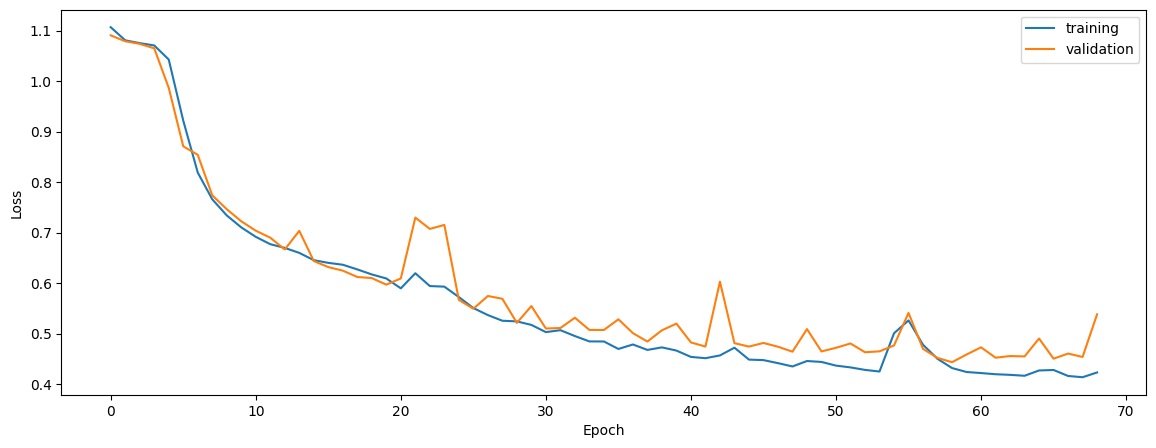

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.8240400550768612


0.8118981160668606


0.799655987212454


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.8563916816845301


0.8236906626711162


0.8063504508036065


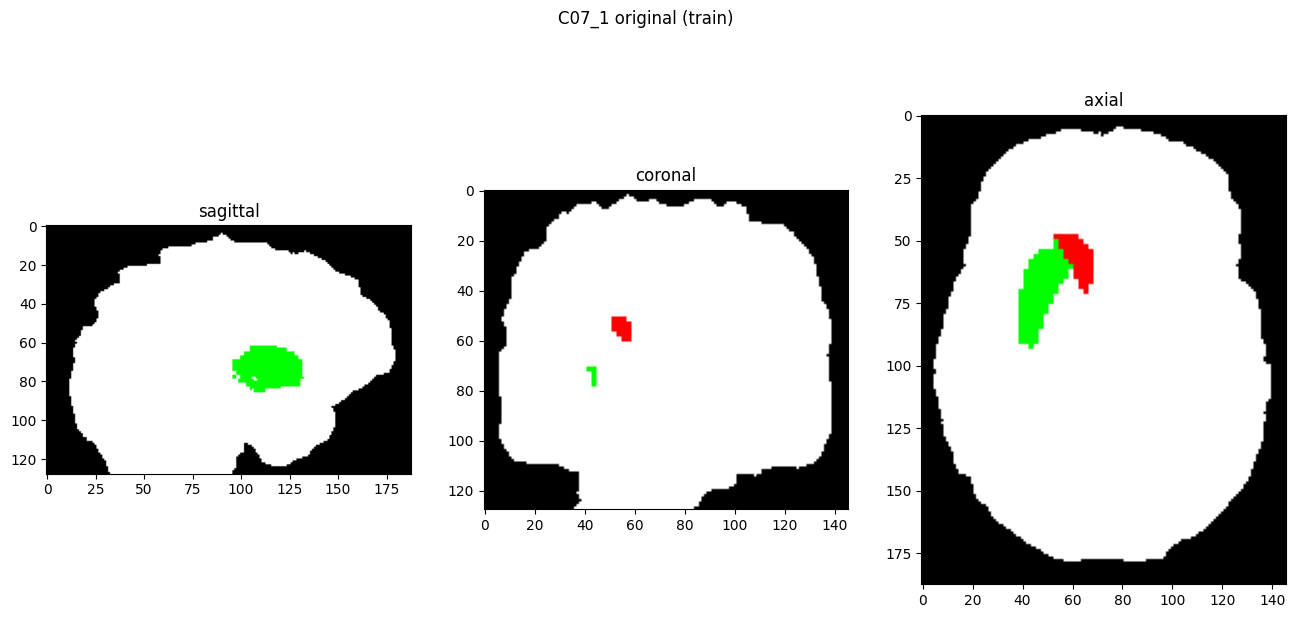

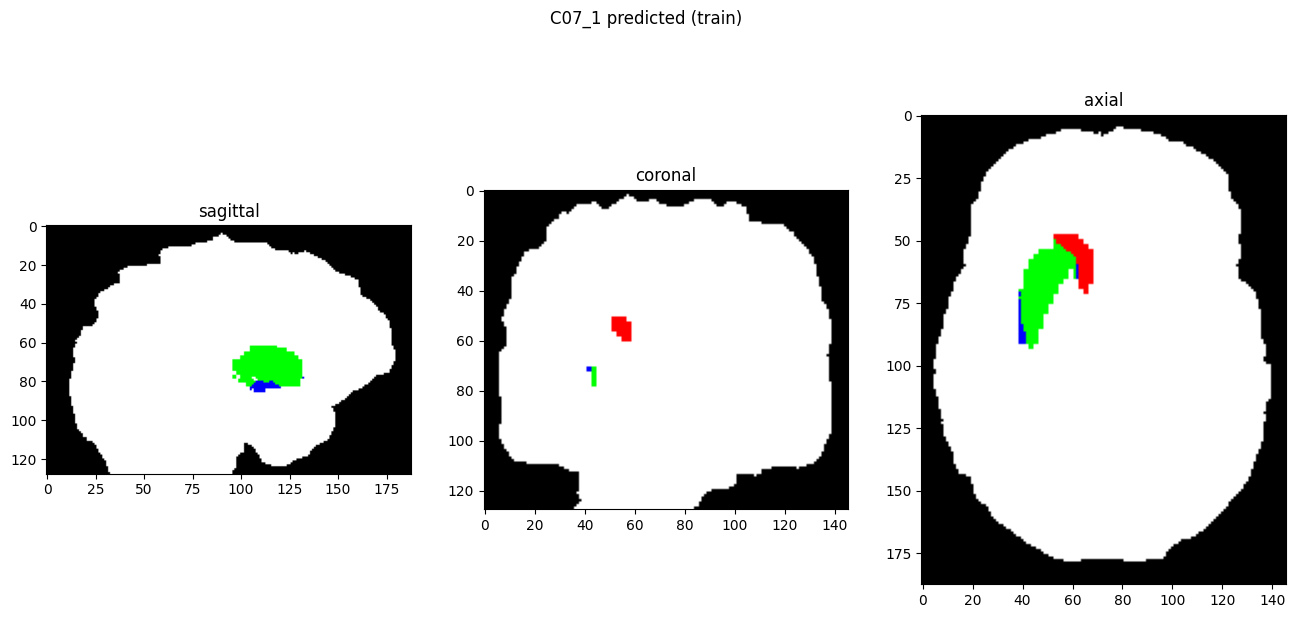

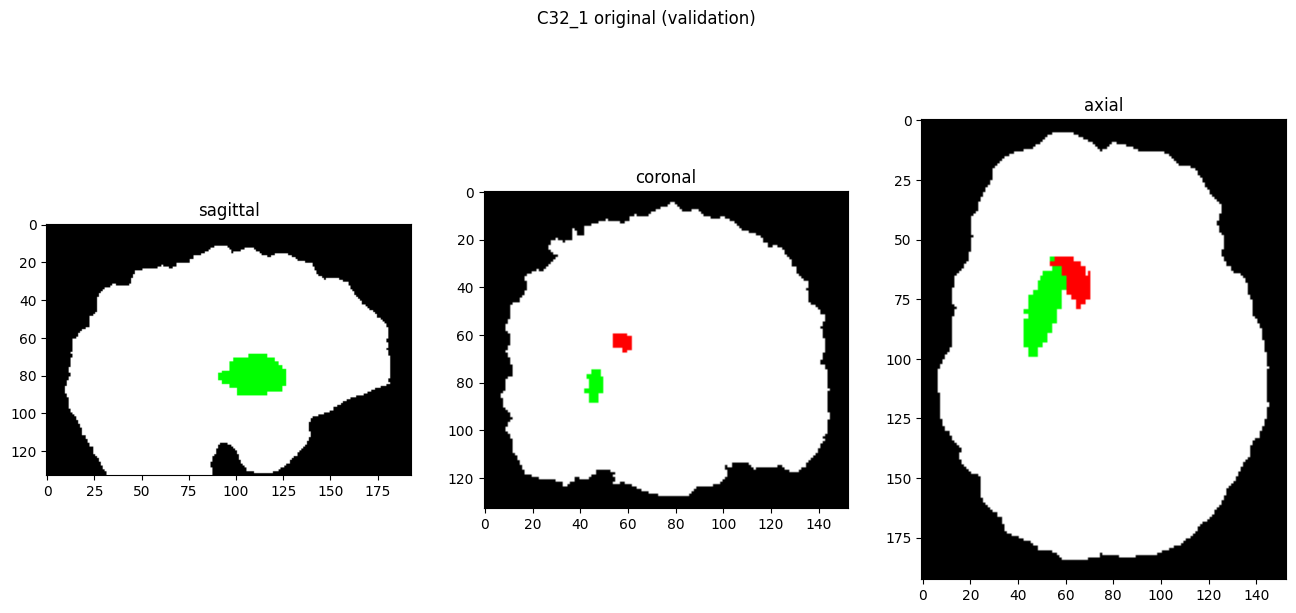

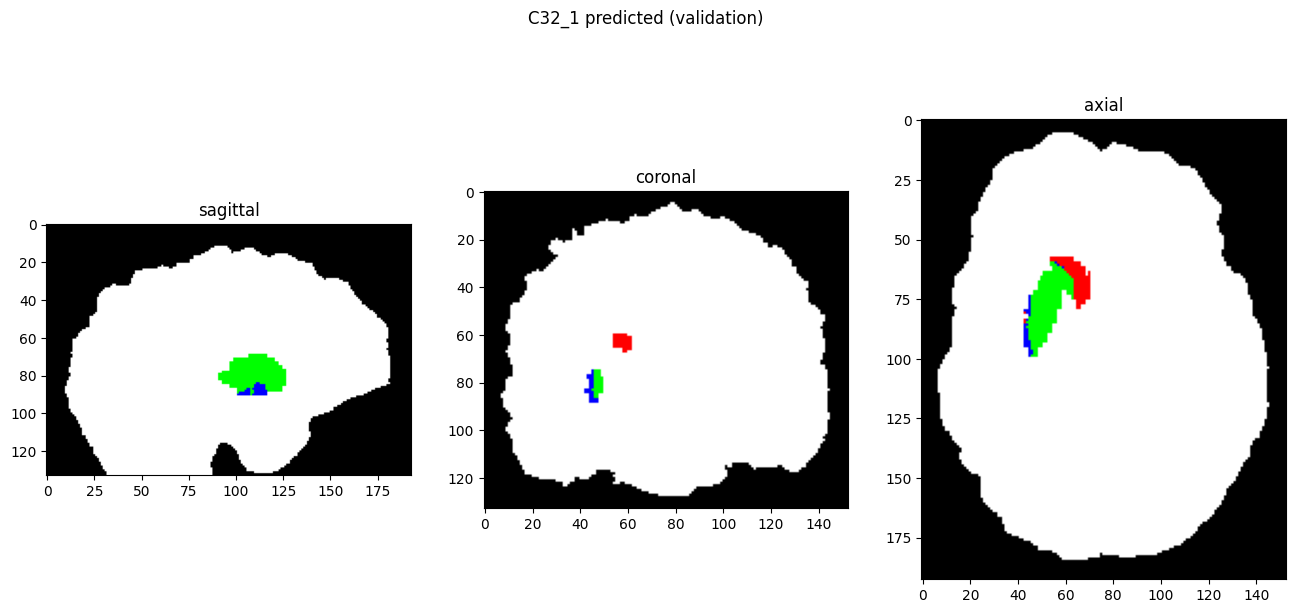

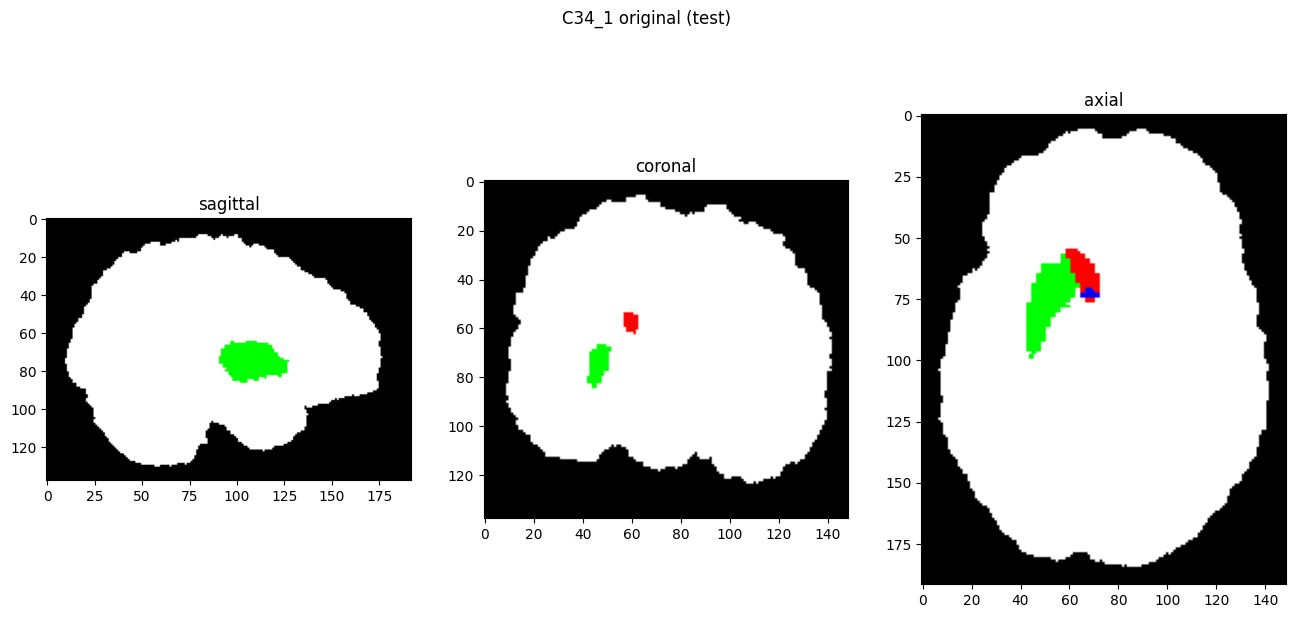

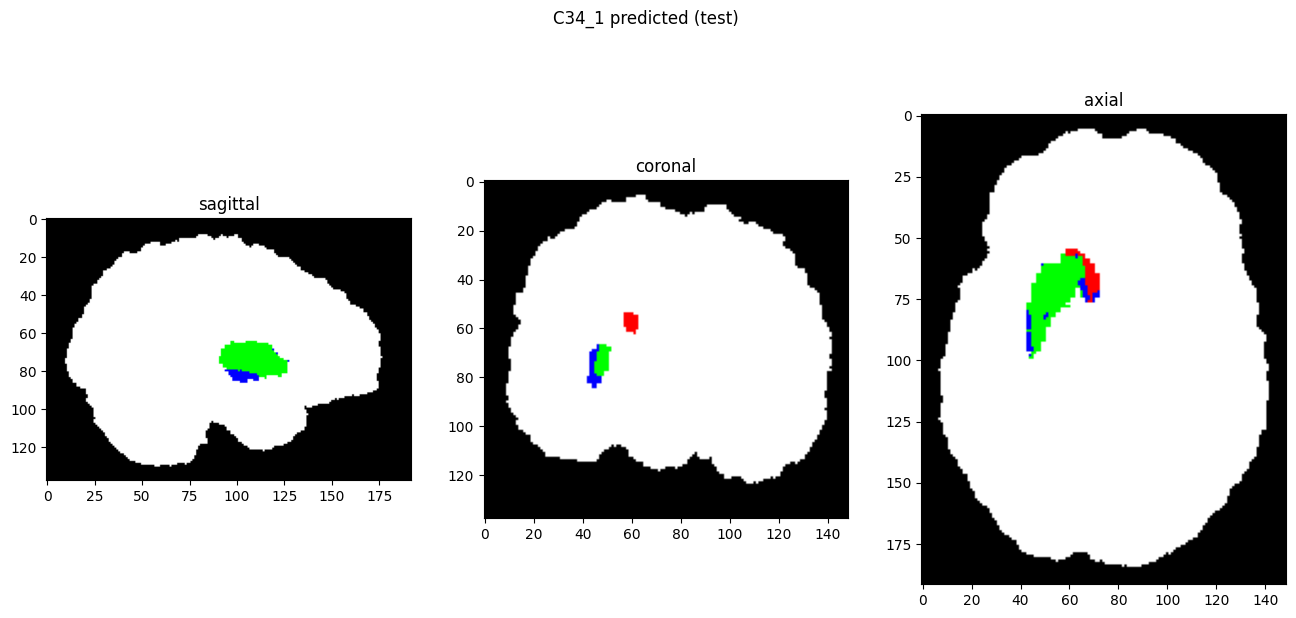

In [9]:
showResults(model, gen, threshold=0)